# Дообучение трансформера DistilBert для соревнования Kaggle Disaster Fake Tweets

In [25]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F
import torchtext

import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

from typing import Union

In [26]:
'''torch.backends.cudnn.deterministic = True 
При установки параметра True, некоторые операции будут выполнены в детерминированном порядке, 
что гарантирует получение одинаковых результатов при каждом запуске кода 
с одинаковым начальным значением (seed).  
'''

torch.backends.cudnn.deterministic = True
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

NUM_EPOCHS = 2

In [27]:
df = pd.read_csv('test.csv')
dfsub = pd.read_csv('sample_submission.csv')
df_train = pd.read_csv('train.csv')

In [28]:
train_texts = df_train.iloc[:5330]['text'].values
train_labels = df_train.iloc[:5330]['target'].values

valid_texts = df_train.iloc[5330:6091]['text'].values
valid_labels = df_train.iloc[5330:6091]['target'].values

test_texts = df_train.iloc[6091:]['text'].values
test_labels = df_train.iloc[6091:]['target'].values

# Токенезация

In [29]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [30]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)

In [31]:
valid_encodings = tokenizer(list(valid_texts), truncation=True, padding=True)

In [32]:
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

#  Подготовка данных для дообучения

In [33]:
class DisastersTweetsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = DisastersTweetsDataset(train_encodings, train_labels)
valid_dataset = DisastersTweetsDataset(valid_encodings, valid_labels)
test_dataset = DisastersTweetsDataset(test_encodings, test_labels)

In [34]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

# Подготовка выбранной моедли для обучения

In [35]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(DEVICE)

# Кол-во параметров модели
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(params)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


66955010


In [36]:
model.train()

optim = torch.optim.Adam(model.parameters(), lr=5e-5)

In [37]:
def computing_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(data_loader):

            ### Подготовка данных
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs['loss'], outputs['logits']

            _, predicted_labels = torch.max(logits, 1)

            num_examples += labels.size(0)

            correct_pred += (predicted_labels == labels).sum()
    return correct_pred.float()/num_examples * 100


In [38]:
start_time = time.time()

for epoch in range(NUM_EPOCHS):

    model.train()

    for batch_idx, batch in enumerate(train_loader):

        # Подготовка данных
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        # Прямой проход
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs['loss'], outputs['logits']

        # Обратный проход 
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Логирование
        if not batch_idx % 32:
            print (f'Epoch: {epoch+1:04d}/{NUM_EPOCHS:04d} | '
                   f'Batch {batch_idx:04d}/{len(train_loader):04d} | '
                   f'Loss: {loss:.4f}')

    model.eval()

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{computing_accuracy(model, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy: '
              f'{computing_accuracy(model, valid_loader, DEVICE):.2f}%')

    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')


print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {computing_accuracy(model, test_loader, DEVICE):.2f}%')

test_accuracy_trained = computing_accuracy(model, test_loader, DEVICE)
test_accuracy_trained = round(computing_accuracy(model, test_loader, DEVICE).item(), 2)
test_accuracy_trained = str(test_accuracy_trained) + '%'

Epoch: 0001/0002 | Batch 0000/0334 | Loss: 0.6923
Epoch: 0001/0002 | Batch 0032/0334 | Loss: 0.5002
Epoch: 0001/0002 | Batch 0064/0334 | Loss: 0.2605
Epoch: 0001/0002 | Batch 0096/0334 | Loss: 0.3595
Epoch: 0001/0002 | Batch 0128/0334 | Loss: 0.4652
Epoch: 0001/0002 | Batch 0160/0334 | Loss: 0.3341
Epoch: 0001/0002 | Batch 0192/0334 | Loss: 0.6485
Epoch: 0001/0002 | Batch 0224/0334 | Loss: 0.3578
Epoch: 0001/0002 | Batch 0256/0334 | Loss: 0.1561
Epoch: 0001/0002 | Batch 0288/0334 | Loss: 0.2722
Epoch: 0001/0002 | Batch 0320/0334 | Loss: 0.6107
training accuracy: 89.25%
valid accuracy: 83.71%
Time elapsed: 1.37 min
Epoch: 0002/0002 | Batch 0000/0334 | Loss: 0.3219
Epoch: 0002/0002 | Batch 0032/0334 | Loss: 0.0676
Epoch: 0002/0002 | Batch 0064/0334 | Loss: 0.0925
Epoch: 0002/0002 | Batch 0096/0334 | Loss: 0.3999
Epoch: 0002/0002 | Batch 0128/0334 | Loss: 0.6733
Epoch: 0002/0002 | Batch 0160/0334 | Loss: 0.4109
Epoch: 0002/0002 | Batch 0192/0334 | Loss: 0.3928
Epoch: 0002/0002 | Batch 022

In [39]:
# Сохранение state_dict (Словаря с обученными весами НС)
torch.save(model.state_dict(), 'Trained_DBert.pth')

# Квантование дообученной модели

In [40]:
'''
Реализован класс ModelQuantizer позволяющий применять квантование с фиксированной точностью.

Метод quantize позволяет работать с тензорами библиотеки Pytorch
    1) Проверка значения bits: при выполнении условия, возвращает исходный тензор без изменения
    2) Бинарная квантизация: (X > 0) создаст булев тензор, true если элемент был больше 0, иначе false
    конвертируем в int чтобы значения были 1 и 0.
    Используем отображение: f(x) = 2 * x - 1 | f(0) = -1, f(1) = 1

Метод quantize_state_dict 
формирует словарь из квантованных тензоров с весами(weights), при этом веса смещения (bias) не затрагиваются

Метод quantize_model получает state_dict используемой модели и применяет к нему квантование,
а также загружает обратно в модель уже квантованные веса 
'''

class ModelQuantizer:
    
    def __init__(self, bits: int):
        self.bits = bits
        
    def quantize(self, X: Union[torch.Tensor, torch.FloatTensor, torch.cuda.FloatTensor]) -> torch.ShortTensor:
        if self.bits > 15:
            return X

        if self.bits == 1:
            return (X > 0).int() * 2 - 1

        scale = 1 << (self.bits - 1)
        return (scale * X).round() / scale

    def quantize_state_dict(self, state_dict: dict) -> dict:
        quantized_state_dict = {}
        for key, value in state_dict.items():
            if isinstance(value, torch.Tensor) and 'weight' in key:
                quantized_state_dict[key] = self.quantize(value)
            else:
                quantized_state_dict[key] = value
        return quantized_state_dict

    def quantize_model(self, model: torch.nn.Module) -> torch.nn.Module:
        state_dict = model.state_dict()
        quantized_state_dict = self.quantize_state_dict(state_dict)
        model.load_state_dict(quantized_state_dict)
        return model

In [41]:
#Если уже имеется дообученная модель, то можно загрузить pth файл с ее параметрами
#state_dict = torch.load('Trained_DBert.pth')    

start_time = time.time()

#Создаём экземпляр класса с параметром bits
quantizer = ModelQuantizer(bits=7)

quantized_model = quantizer.quantize_model(model)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Время выполнения квантования: {elapsed_time:.4f} секунд")

#Оценка квантованной модели на тестовой выборке 
model.eval()
print(f'Test accuracy: {computing_accuracy(model, test_loader, DEVICE):.2f}%')

#Сохранение квантованных весов
torch.save(model.state_dict(), 'quantized(7)_DBERT.pth')



Время выполнения квантования: 0.0210 секунд
Test accuracy: 81.87%


In [42]:
state_dict_txt = torch.load('quantized(7)_DBERT.pth')

state_dict_str = str(state_dict_txt)

with open('quantized(7)_DBERT.txt', 'w', encoding='utf-8') as file:
    file.write(state_dict_str)

In [43]:
import pandas as pd

# Создание имен колонок от 10 до 1
columns = list(range(10, 0, -1))

# Создание DataFrame с двумя строками и 10 колонками
df = pd.DataFrame(index=['до квантования', 'после квантования'], columns=columns)

# Добавление заголовка "кол-во бит" для столбцов
df.columns.name = 'кол-во бит'

# Вывод DataFrame
df

кол-во бит,10,9,8,7,6,5,4,3,2,1
до квантования,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
после квантования,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df

кол-во бит,10,9,8,7,6,5,4,3,2,1
до квантования,82.65%,82.65%,82.65%,82.65%,82.65%,82.65%,82.65%,82.65%,82.65%,82.65%
после квантования,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
for i in reversed(range(1, 11)):
    model.load_state_dict(torch.load('Trained_DBert.pth'))
    quantizer = ModelQuantizer(bits=i)
    quantized_model = quantizer.quantize_model(model)
    model.eval()
    print(f'Test accuracy bits {i}: {computing_accuracy(model, test_loader, DEVICE):.2f}%')
    #test_accuracy_trained = computing_accuracy(model, test_loader, DEVICE)
    test_accuracy_trained = round(computing_accuracy(model, test_loader, DEVICE).item(), 2)
    test_accuracy_trained = str(test_accuracy_trained) + '%'
    df.loc['после квантования'][i] = test_accuracy_trained
print('Done')


Test accuracy bits 10: 82.65%
Test accuracy bits 9: 82.59%
Test accuracy bits 8: 82.59%
Test accuracy bits 7: 81.87%
Test accuracy bits 6: 82.00%
Test accuracy bits 5: 72.73%
Test accuracy bits 4: 50.79%
Test accuracy bits 3: 53.42%
Test accuracy bits 2: 53.42%
Test accuracy bits 1: 48.49%
Done


In [58]:
df

кол-во бит,10,9,8,7,6,5,4,3,2,1
до квантования,82.65%,82.65%,82.65%,82.65%,82.65%,82.65%,82.65%,82.65%,82.65%,82.65%
после квантования,82.65%,82.59%,82.59%,81.87%,82.0%,72.73%,50.79%,53.42%,53.42%,48.49%


# Построение гистограмм распределения весов по слоям(weights и bias)

In [59]:
model.load_state_dict(torch.load('Trained_DBert.pth'))
quantizer = ModelQuantizer(bits=7)
quantized_model = quantizer.quantize_model(model)

In [60]:
torch.save(model.state_dict(), 'qDBERT(7).pth')

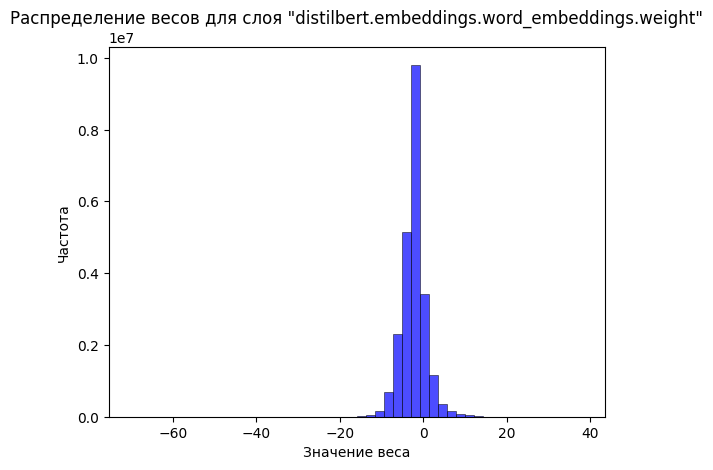

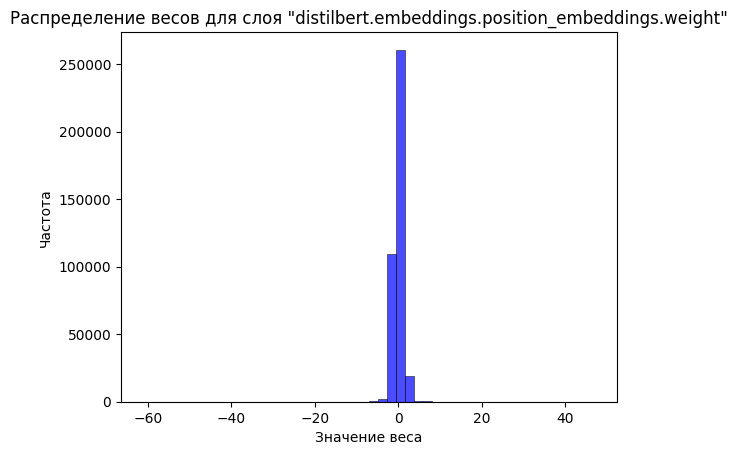

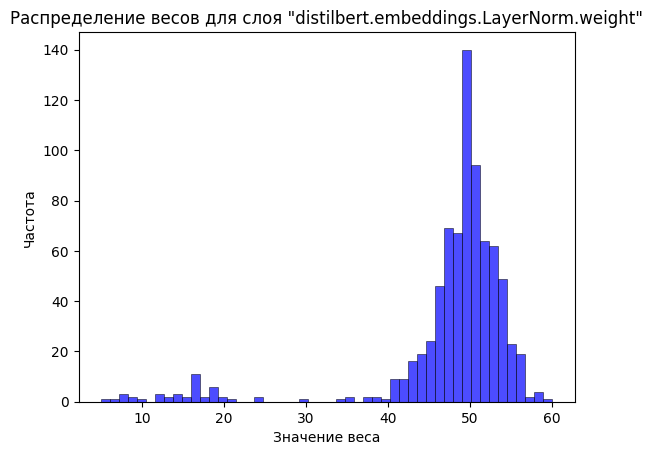

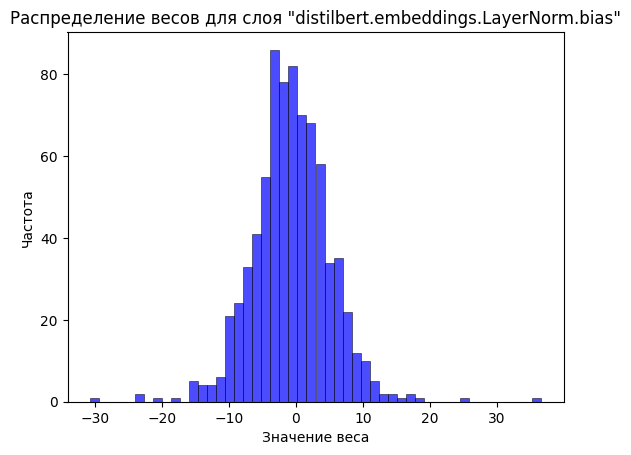

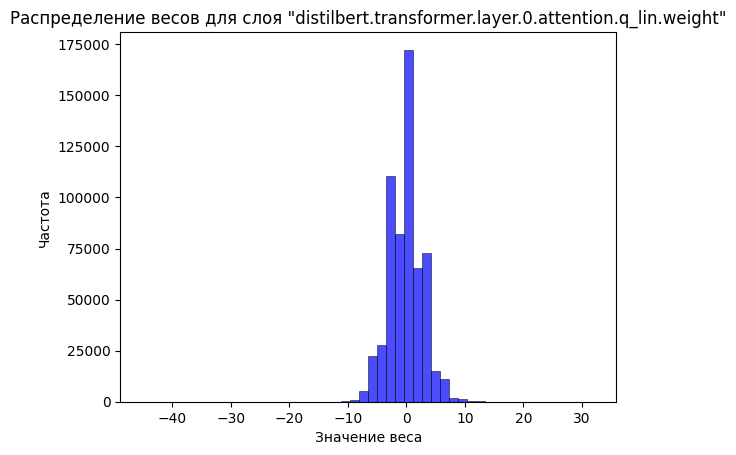

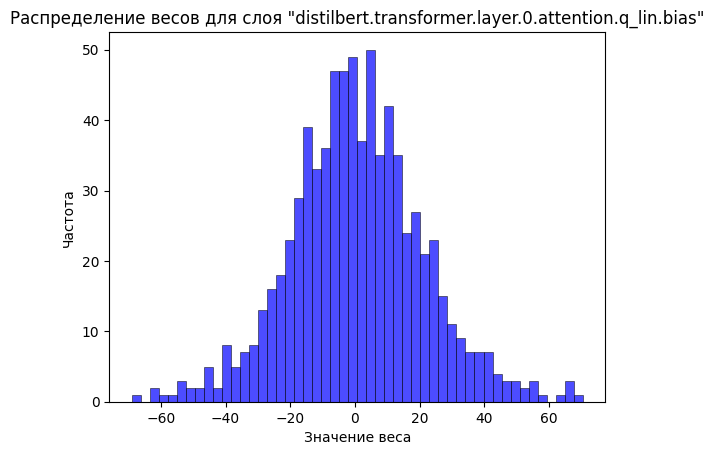

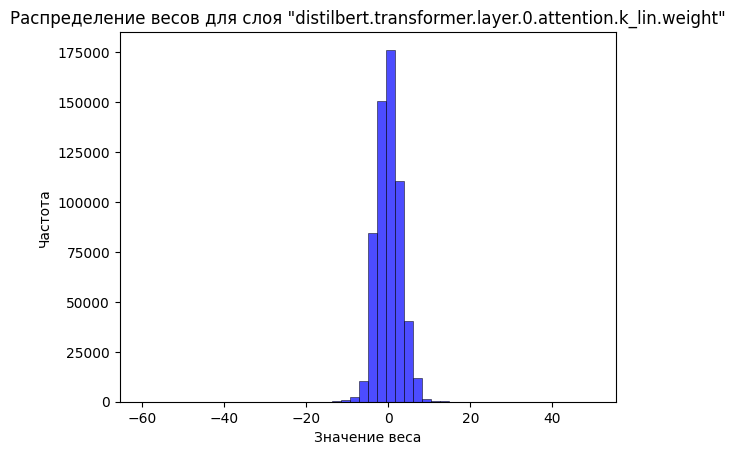

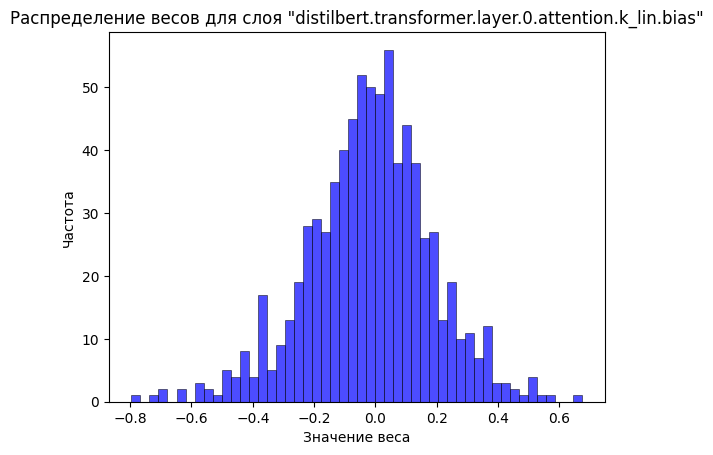

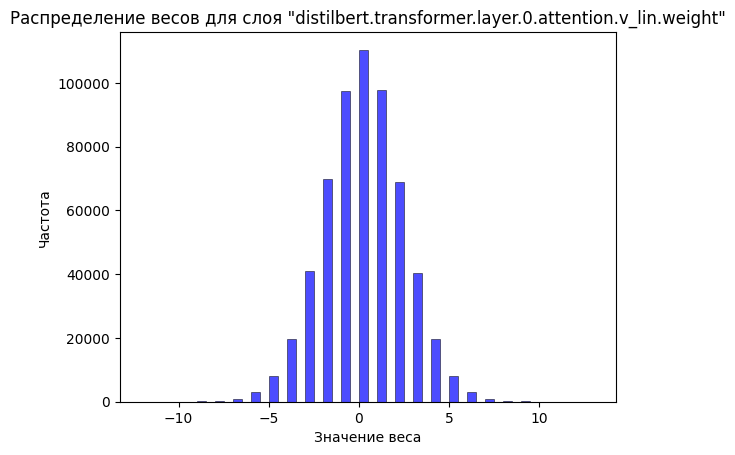

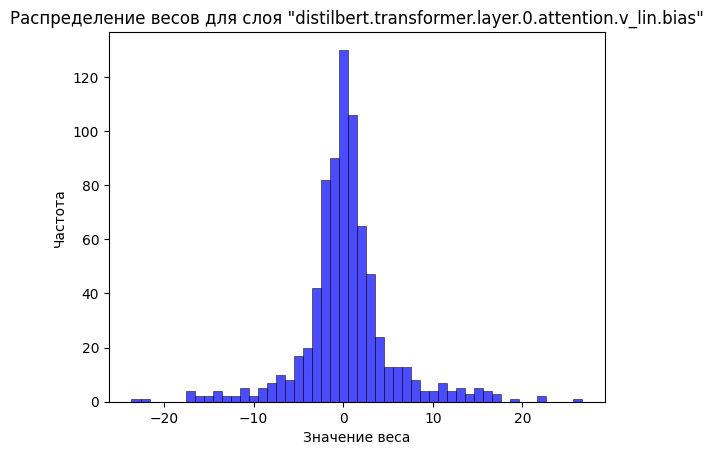

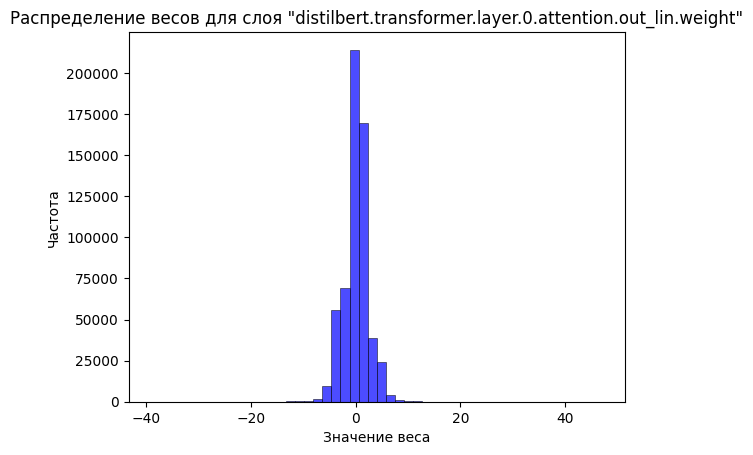

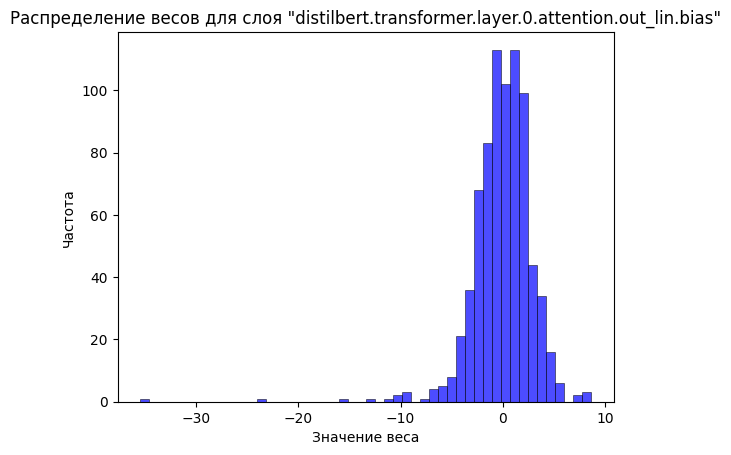

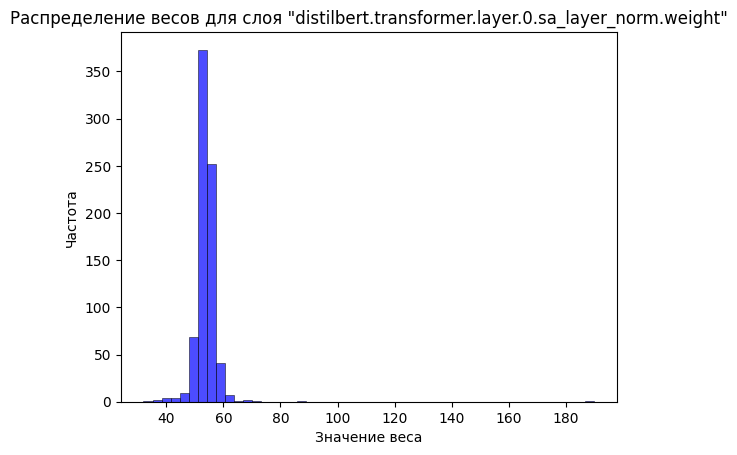

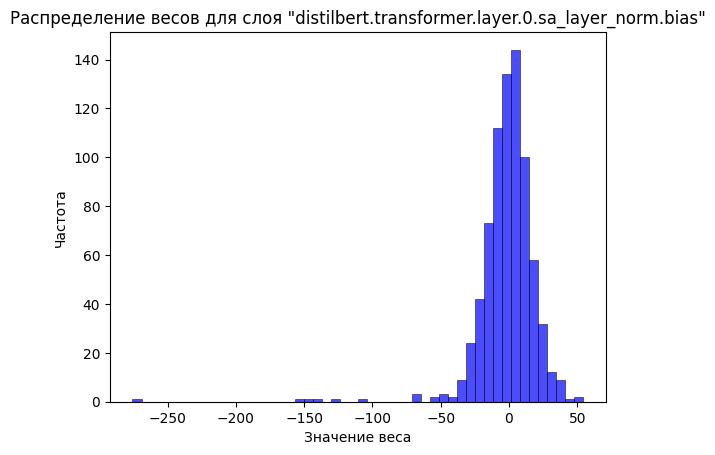

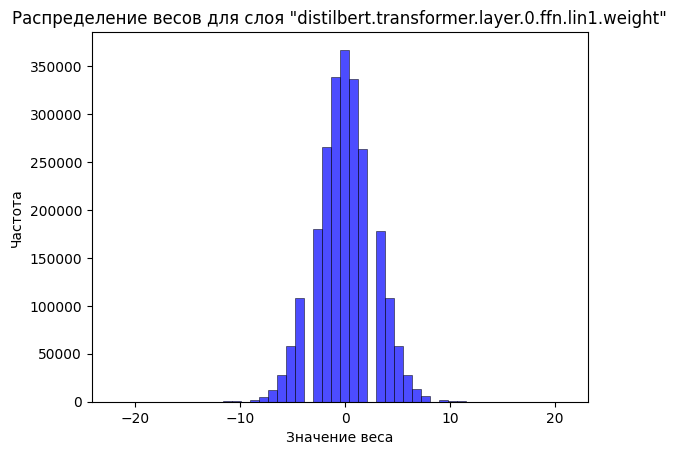

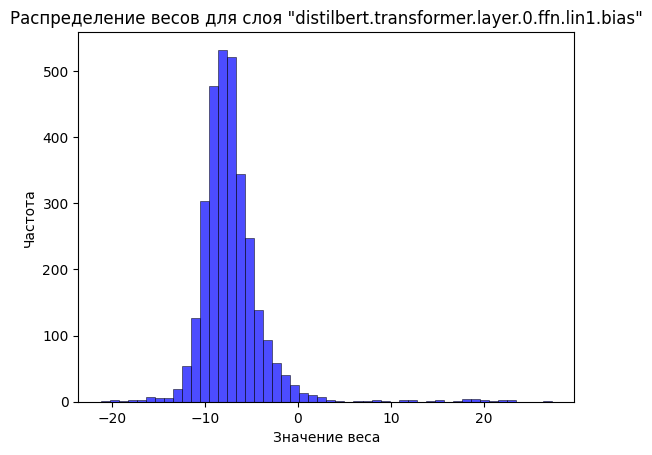

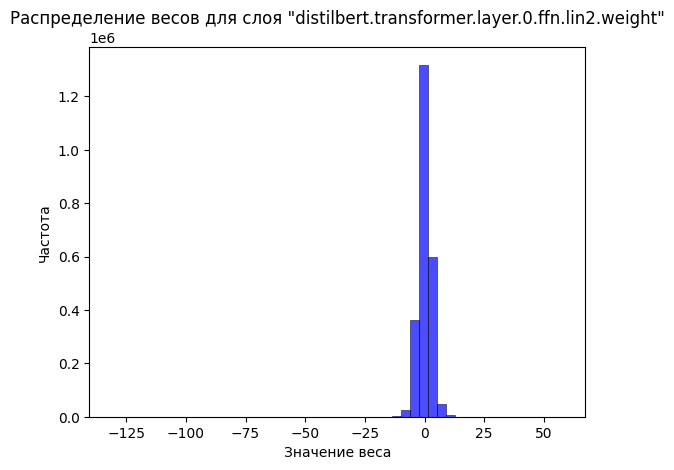

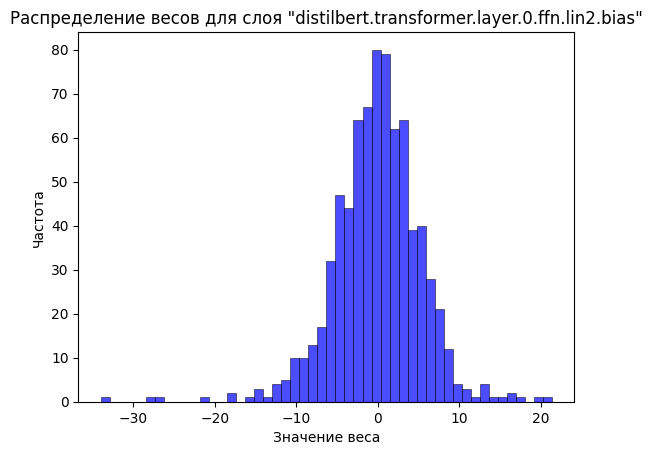

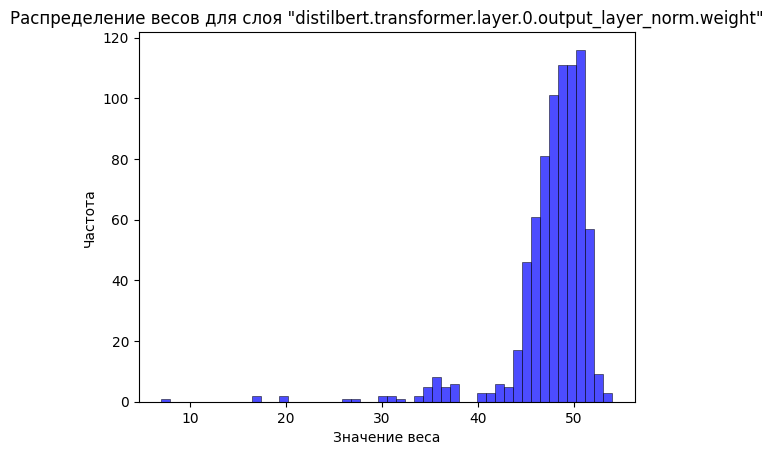

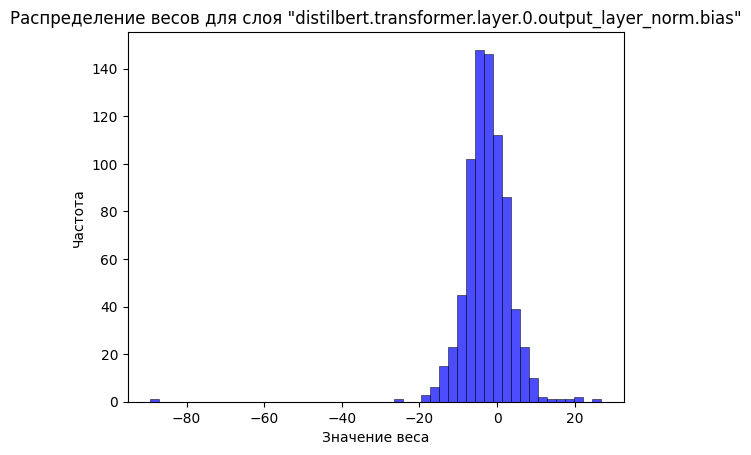

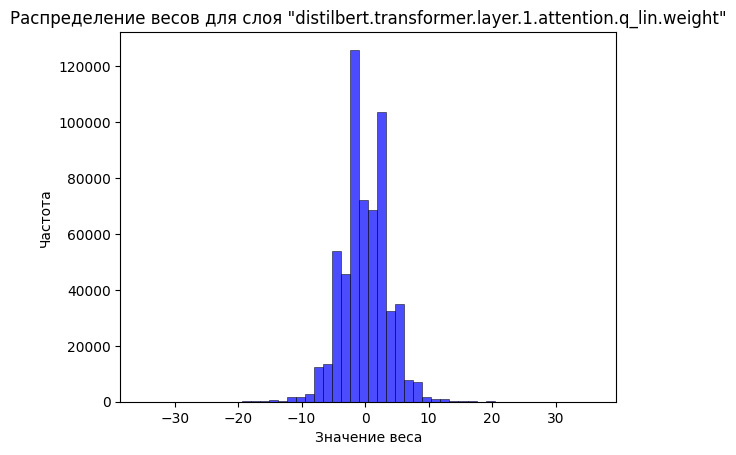

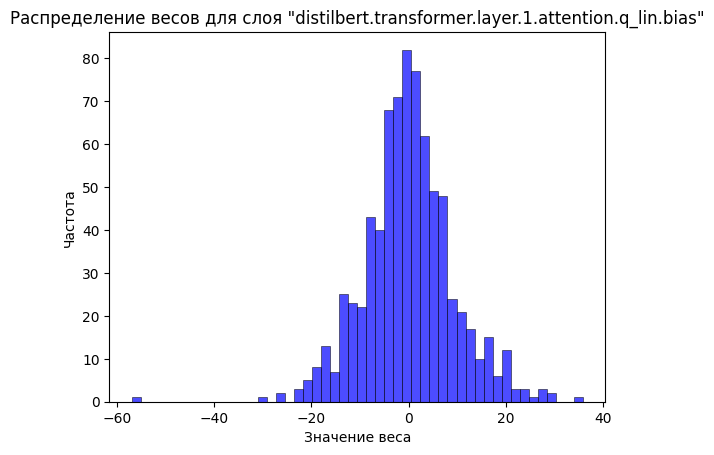

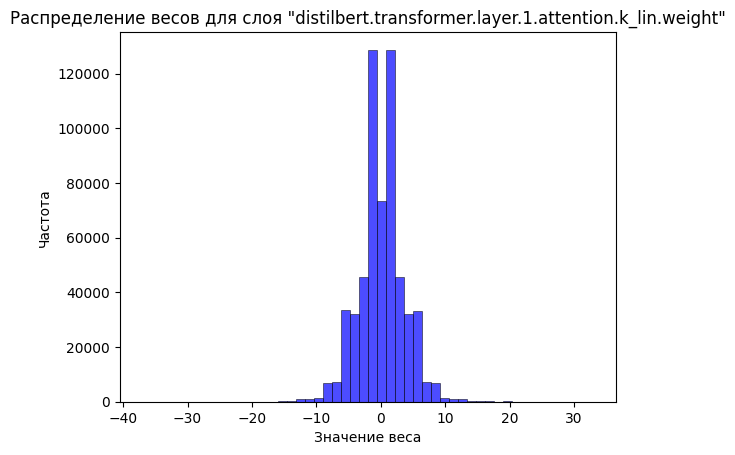

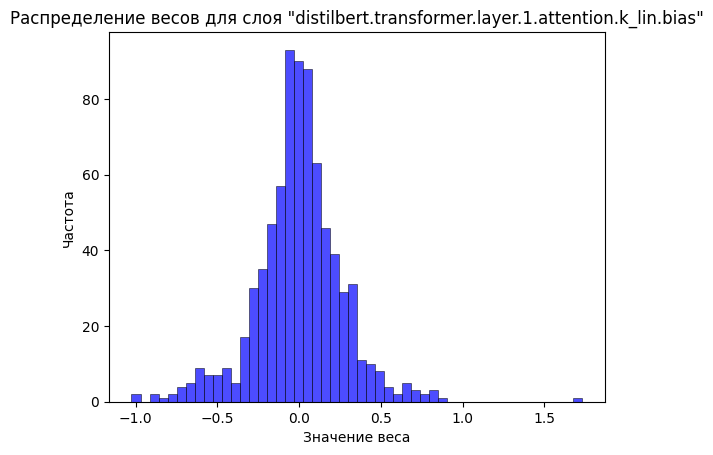

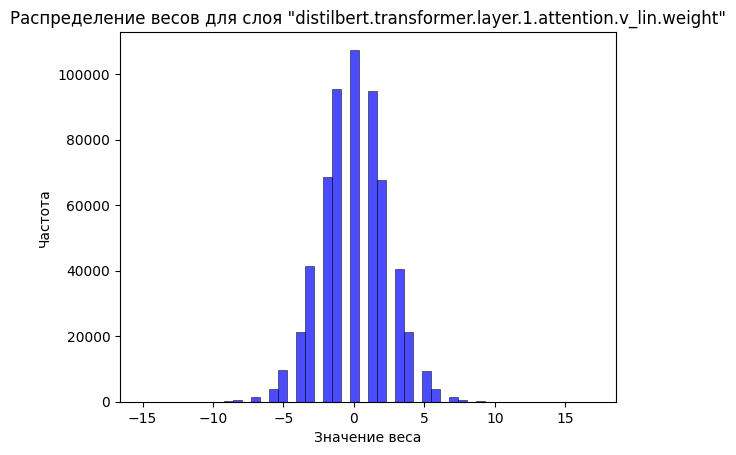

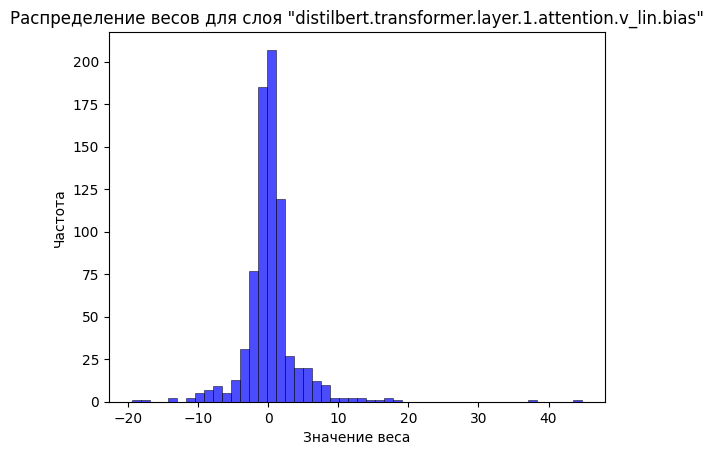

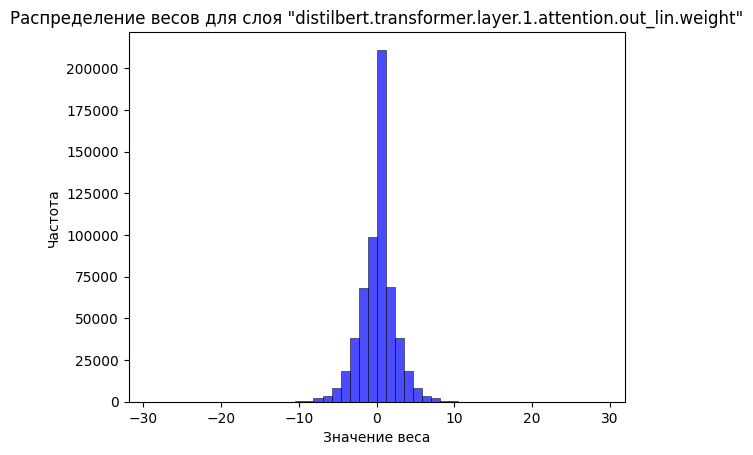

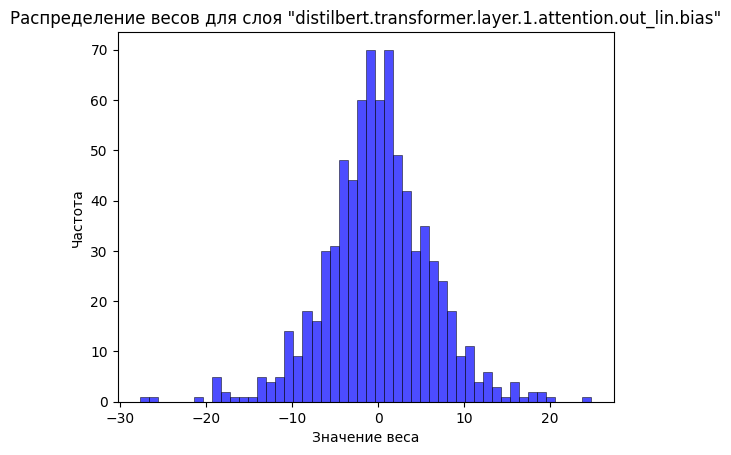

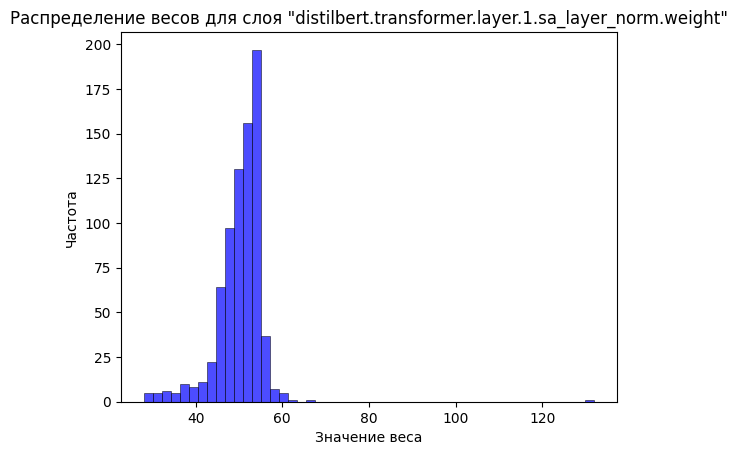

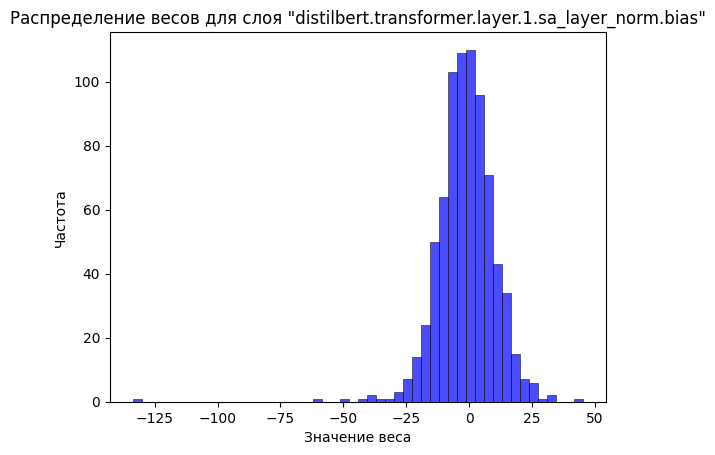

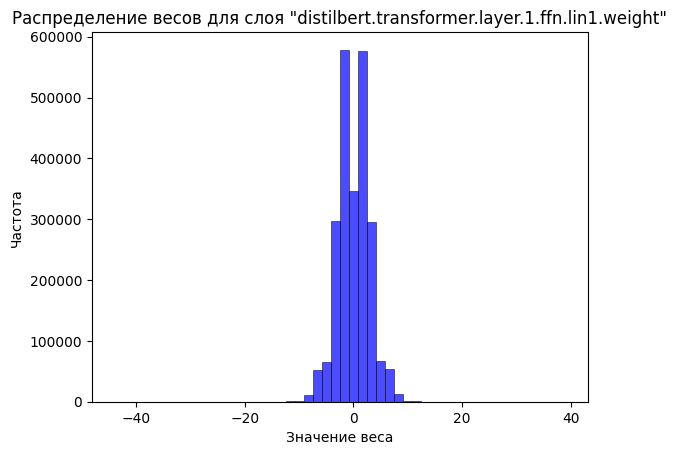

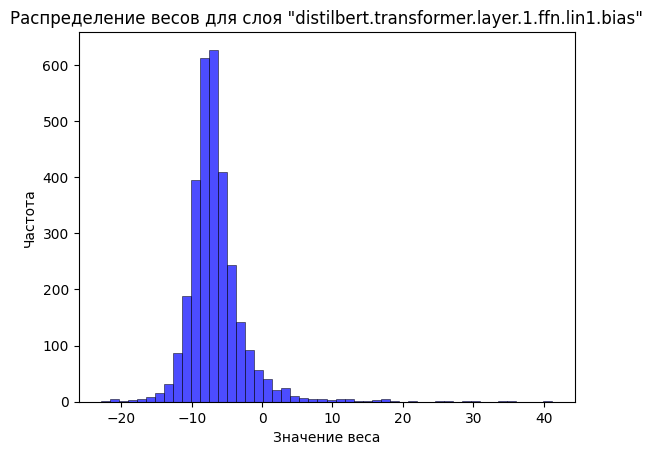

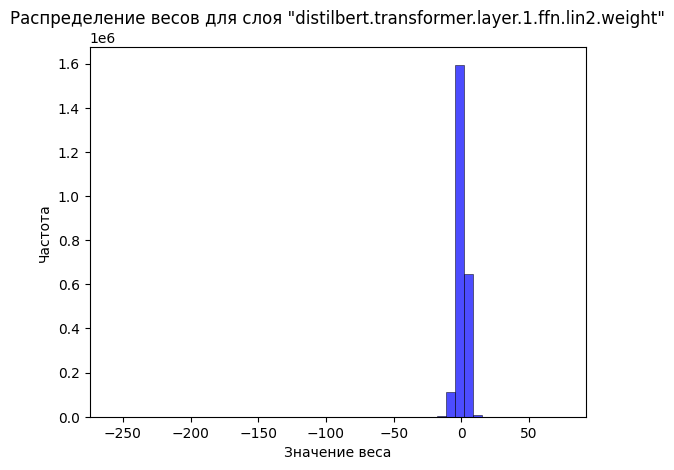

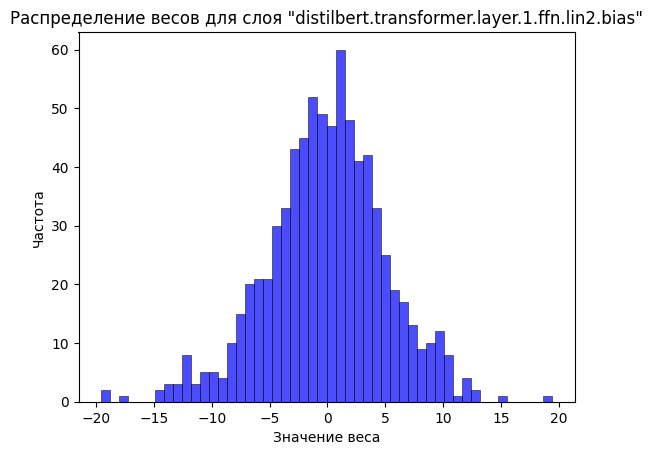

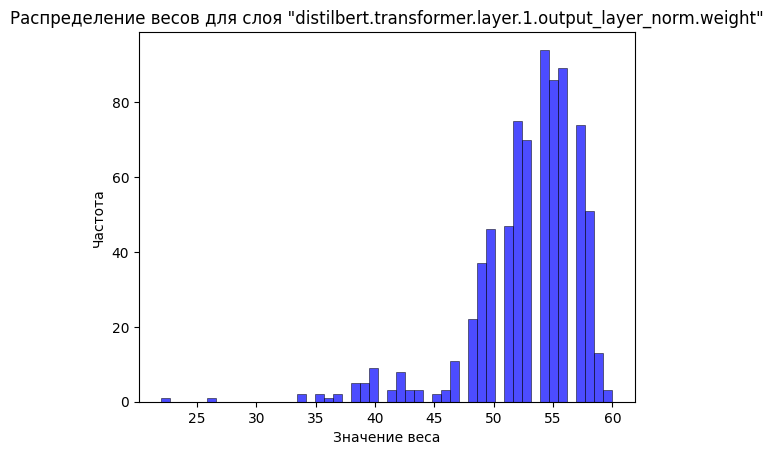

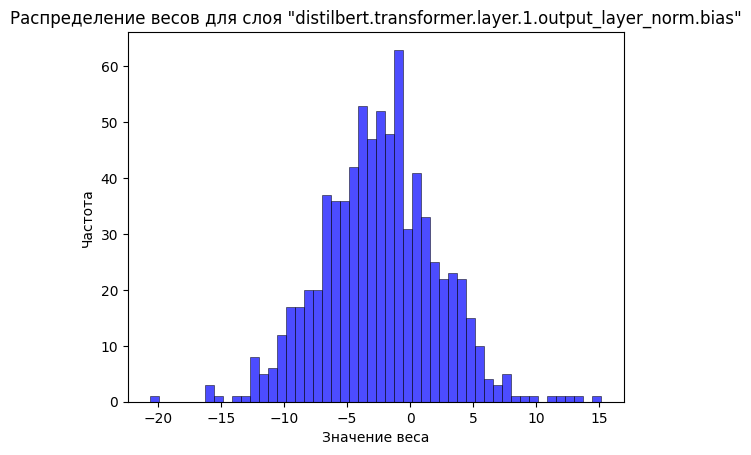

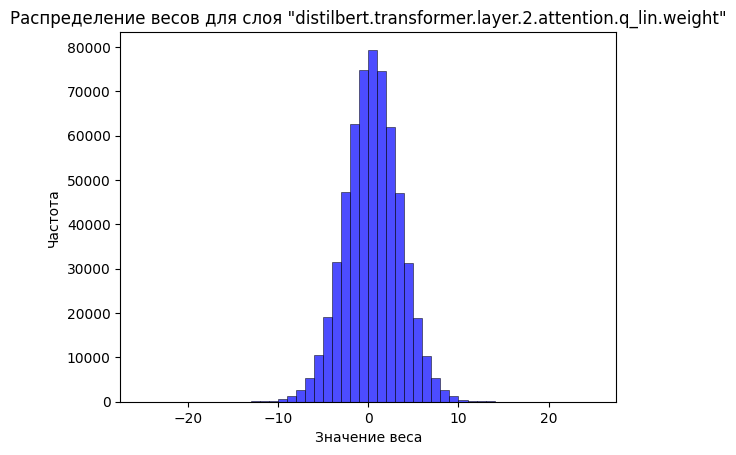

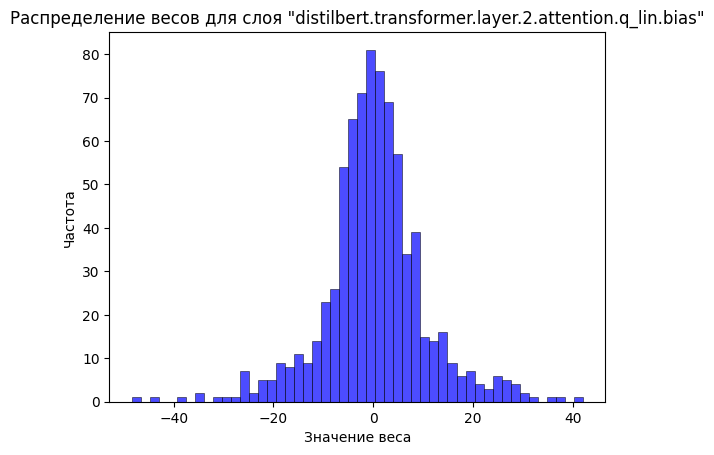

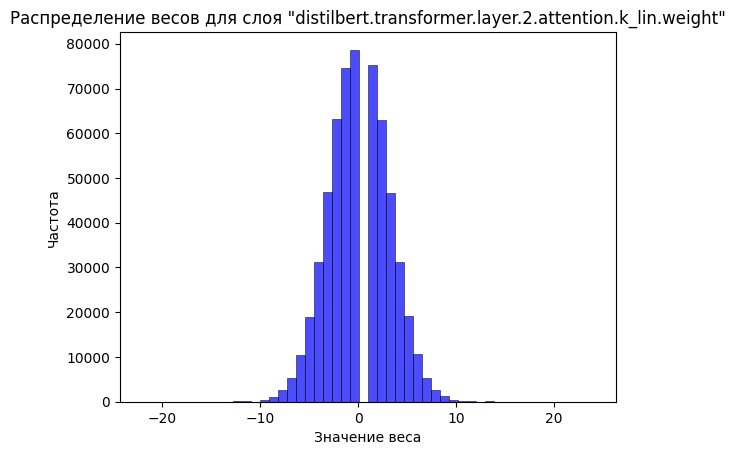

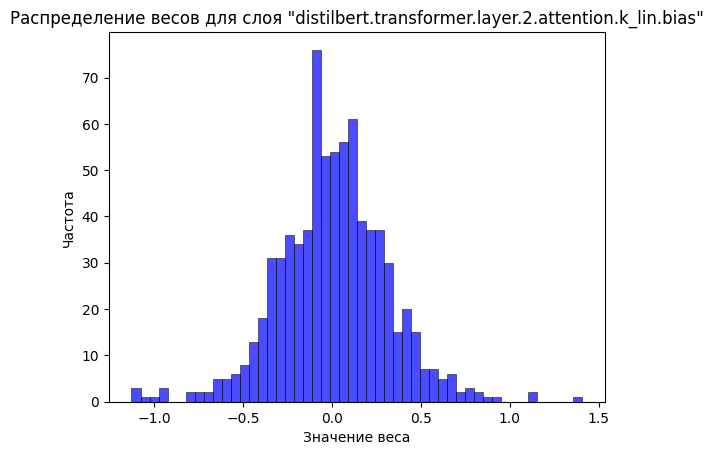

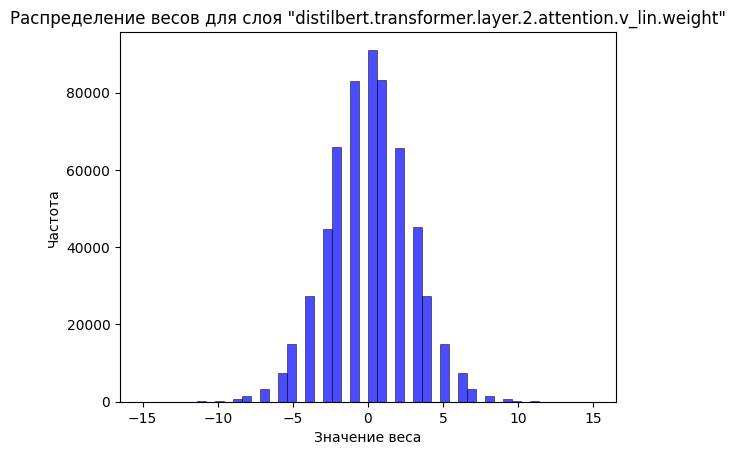

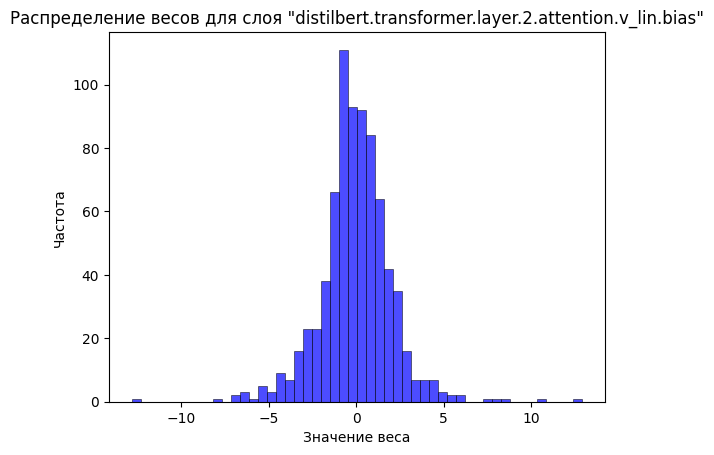

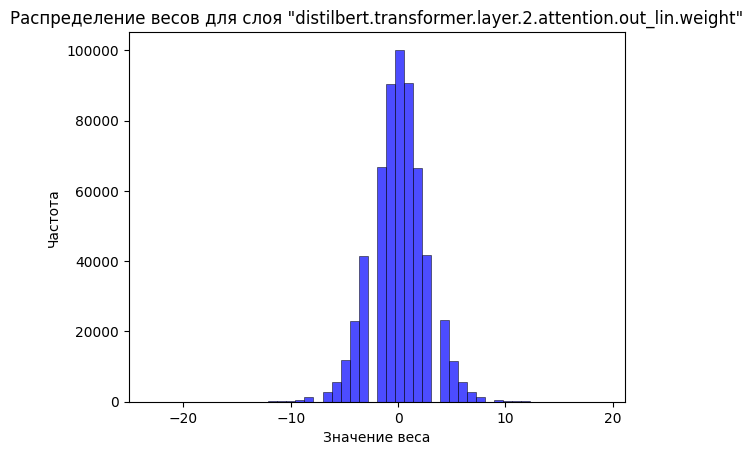

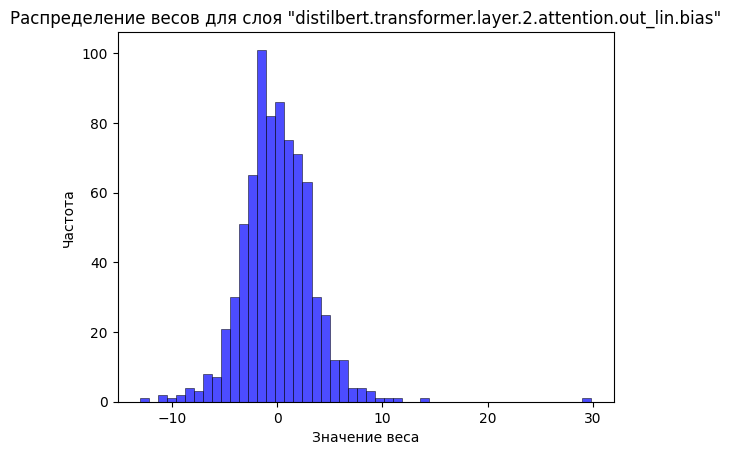

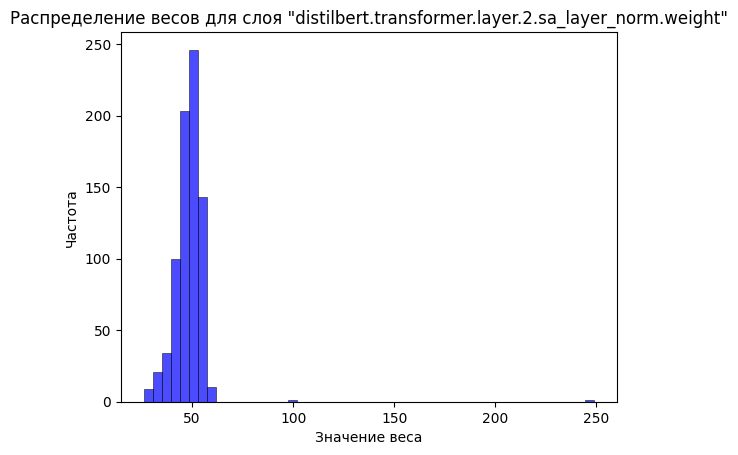

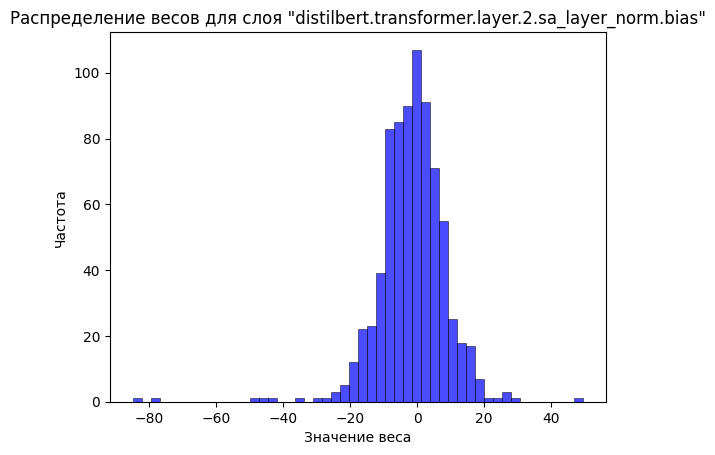

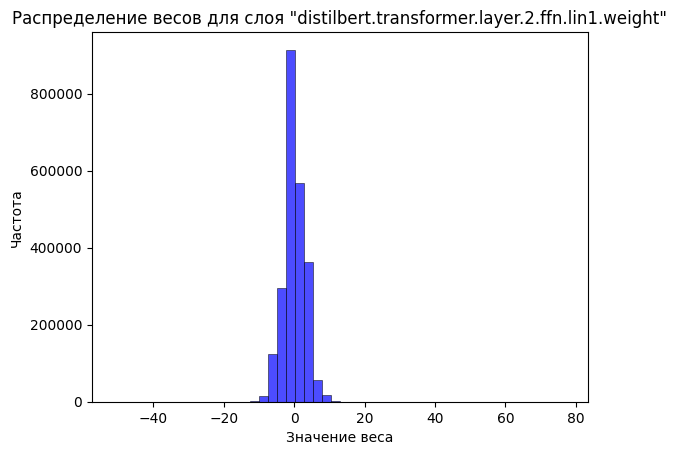

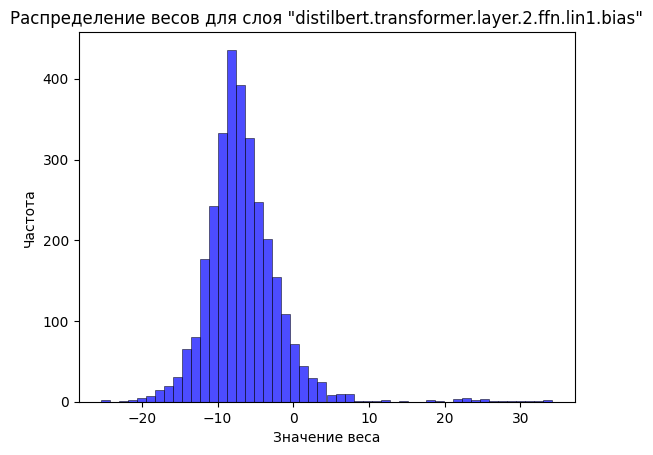

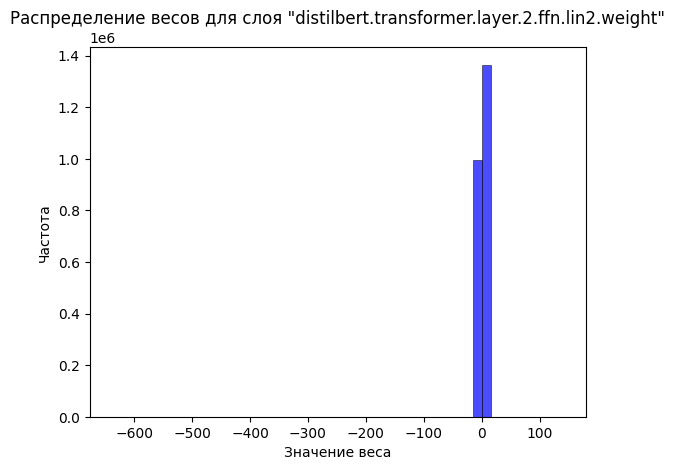

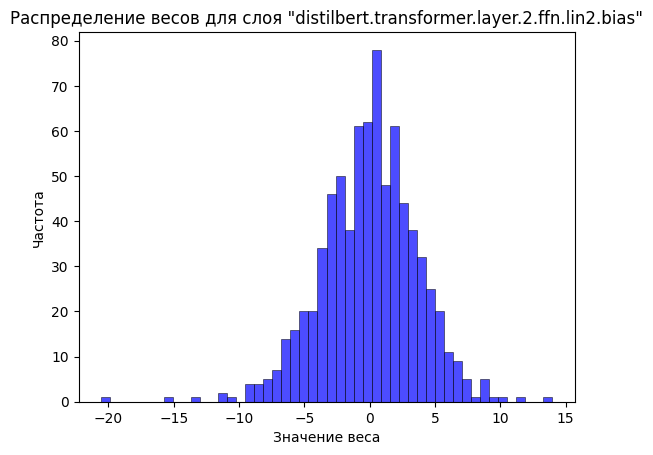

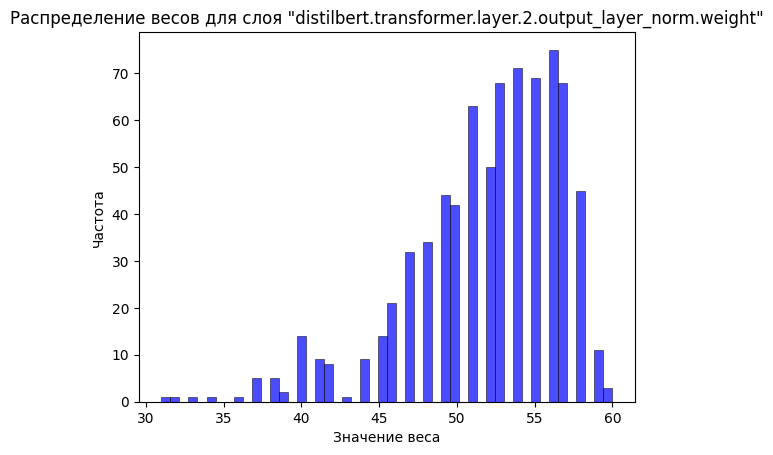

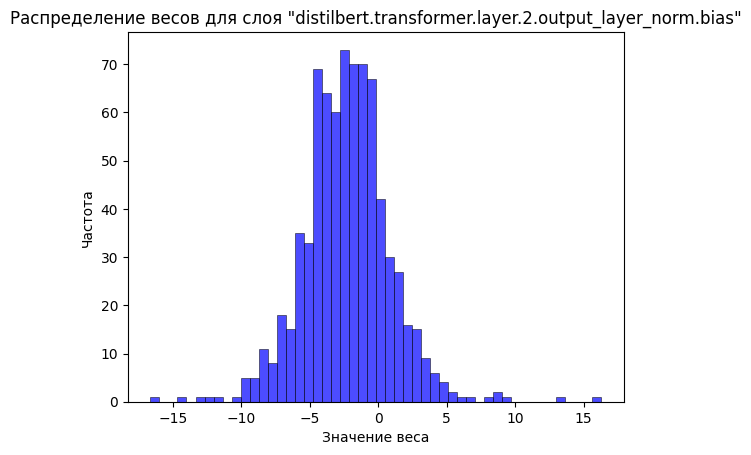

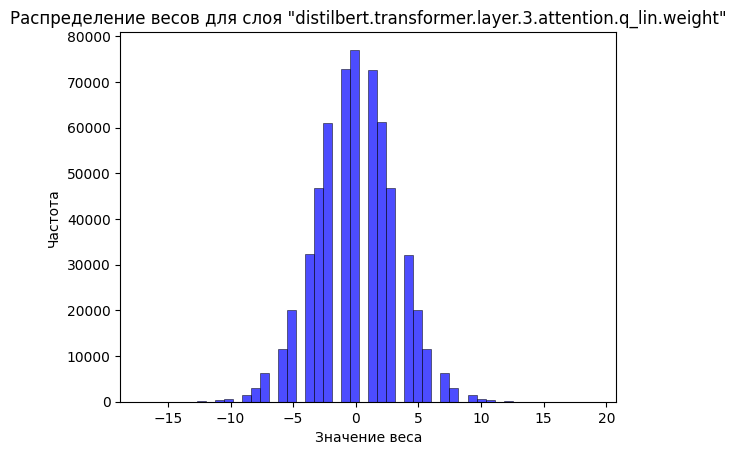

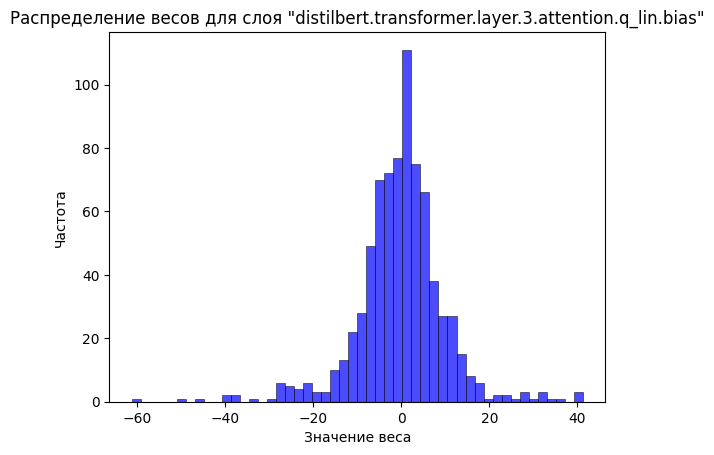

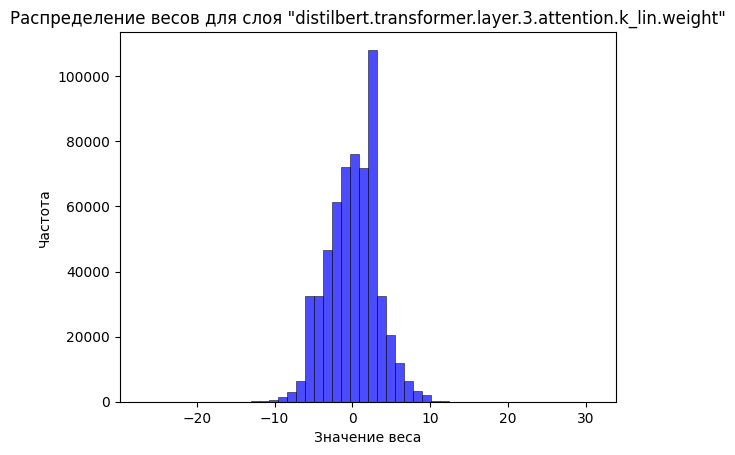

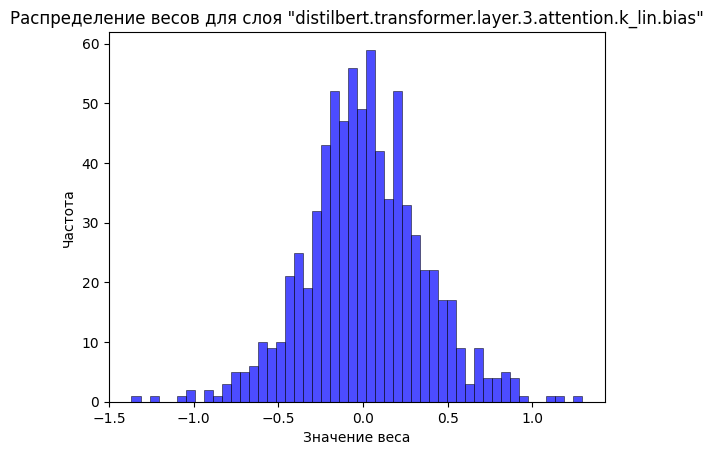

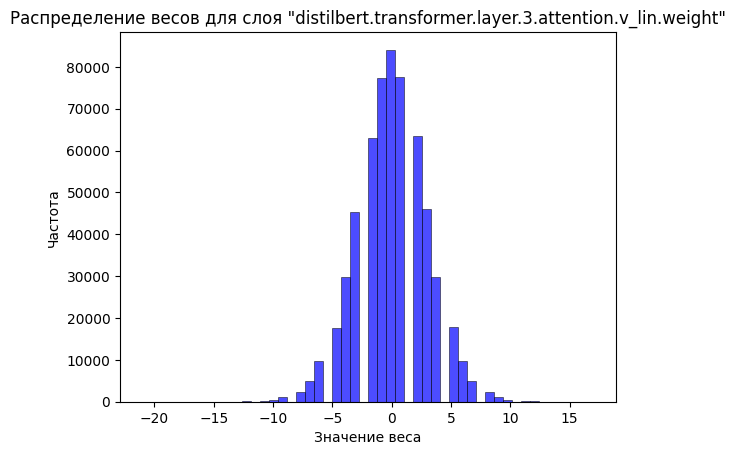

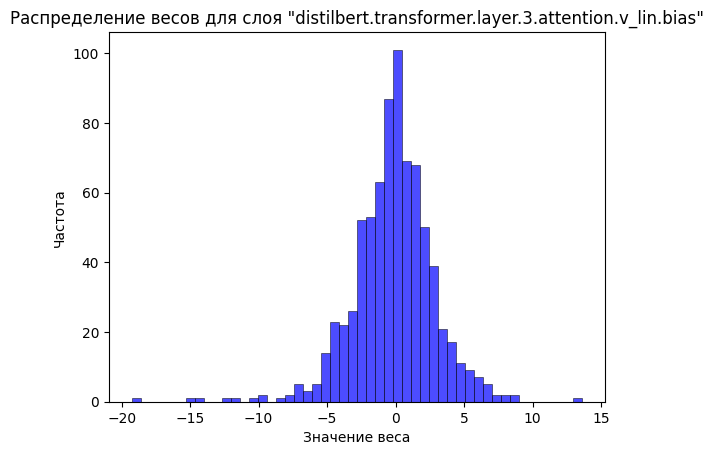

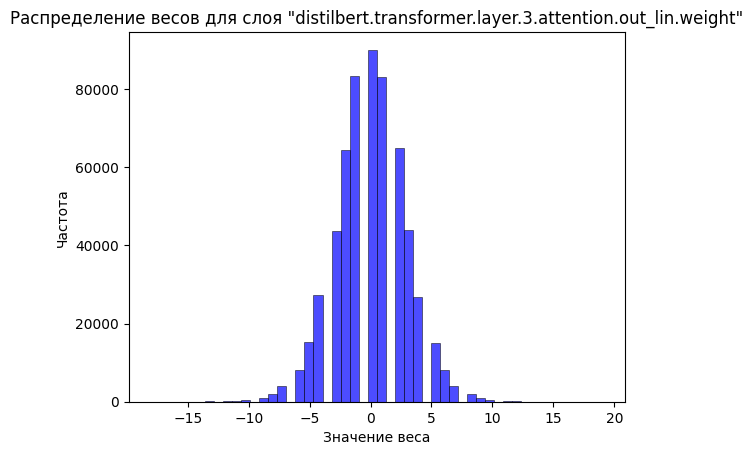

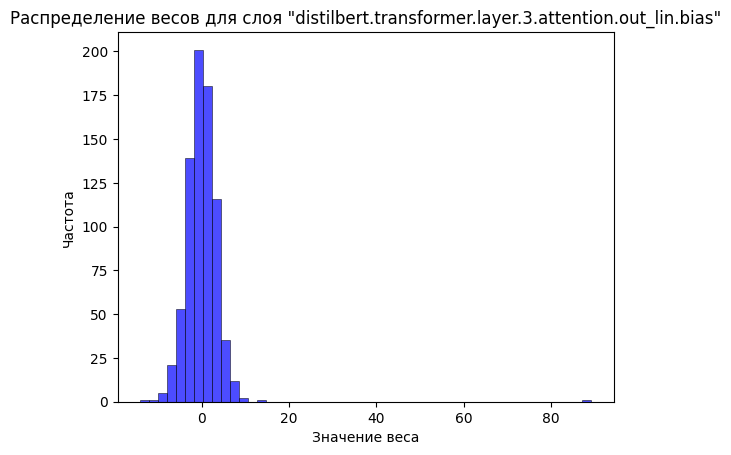

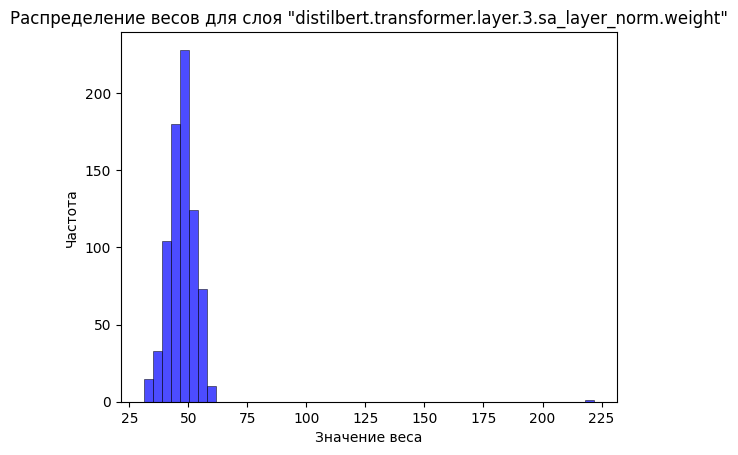

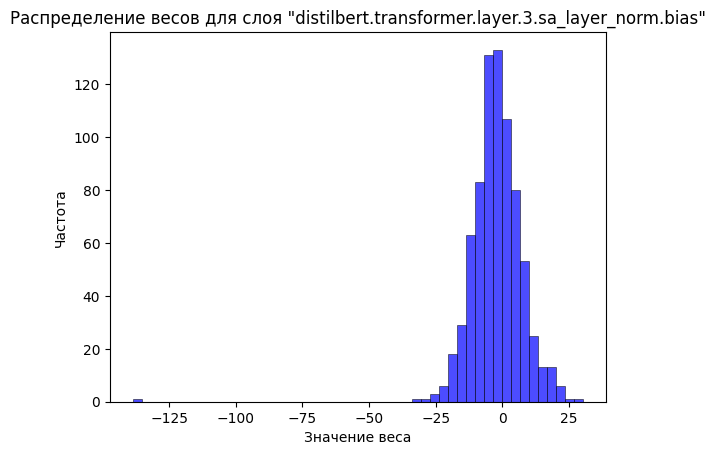

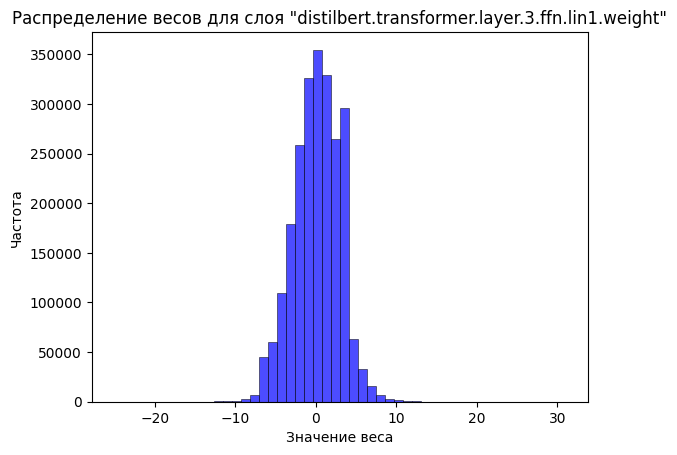

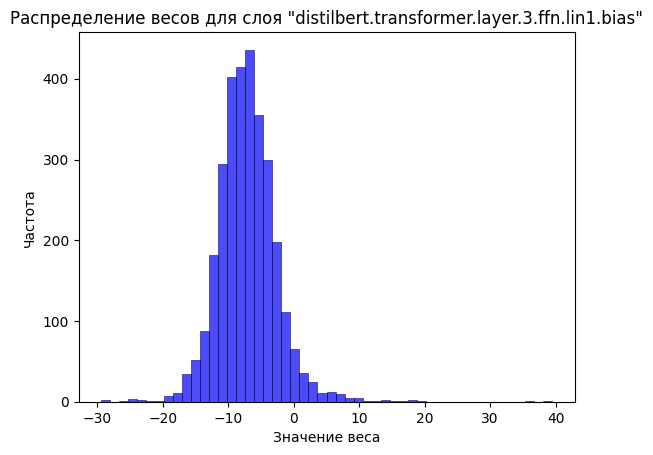

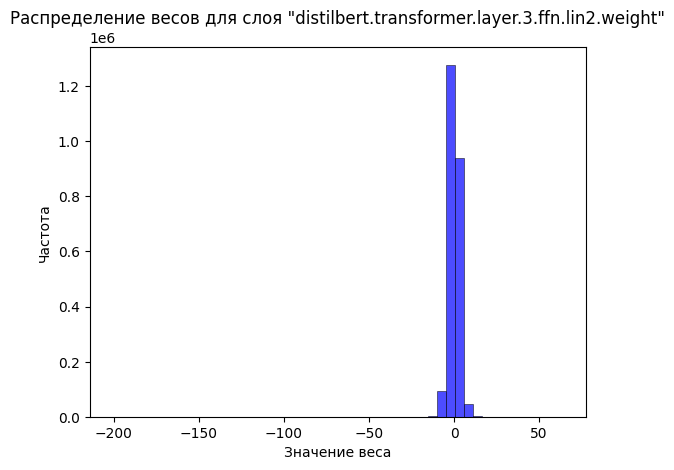

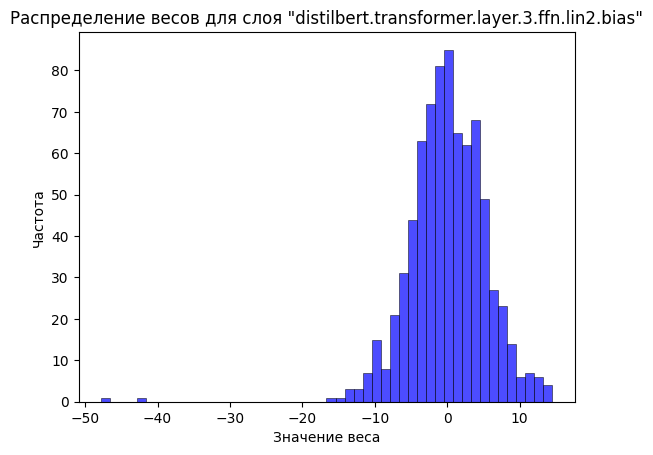

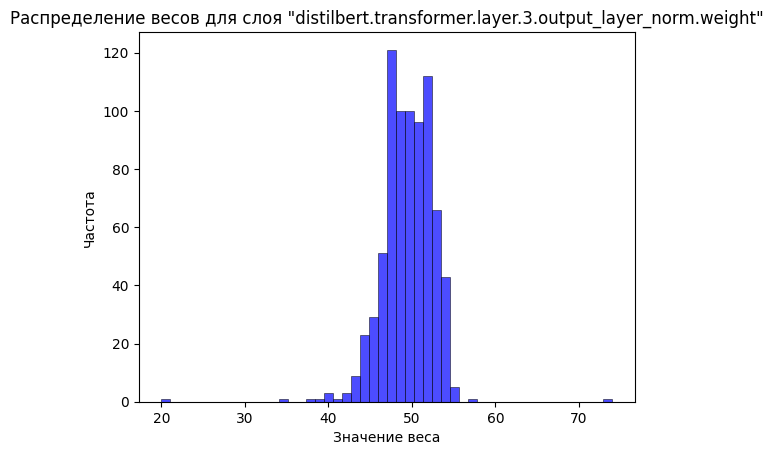

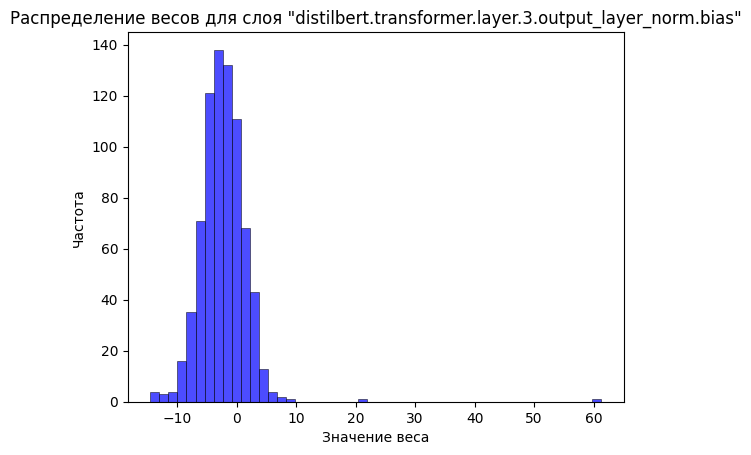

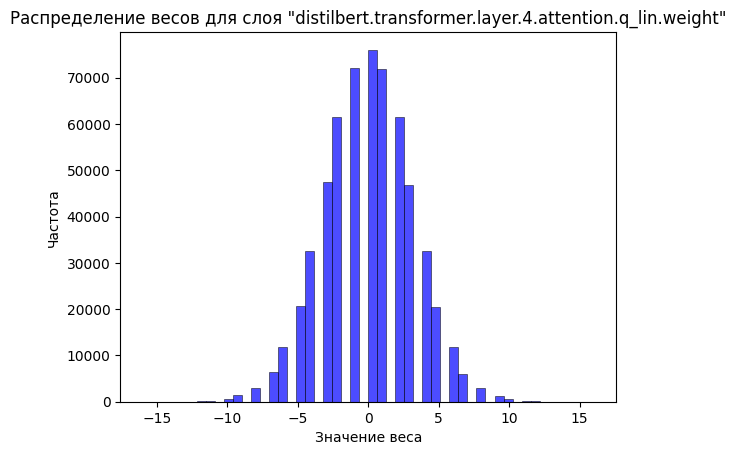

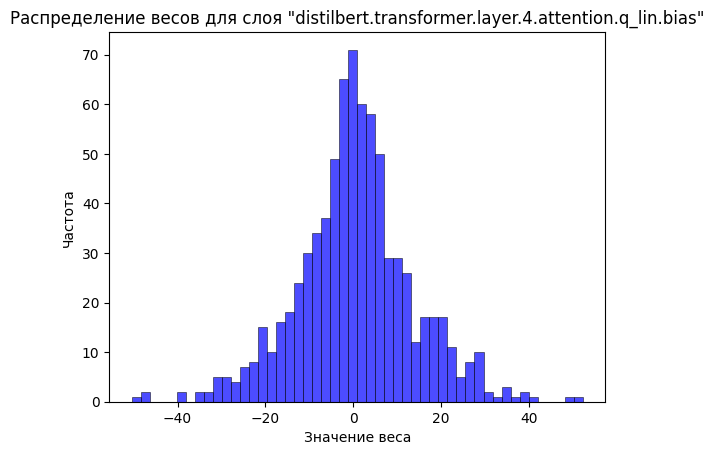

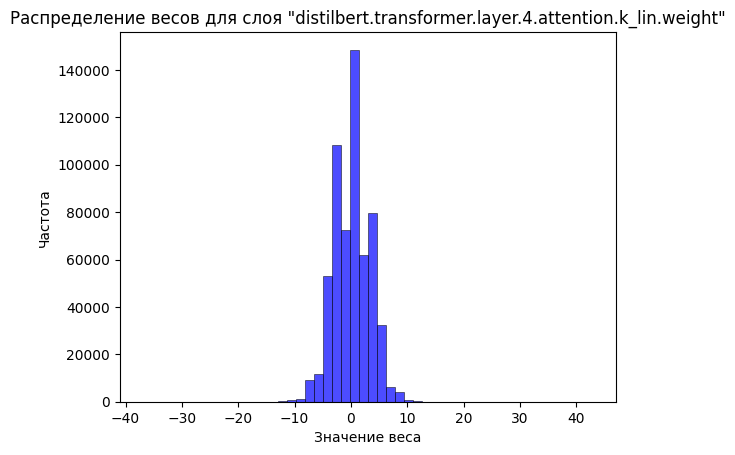

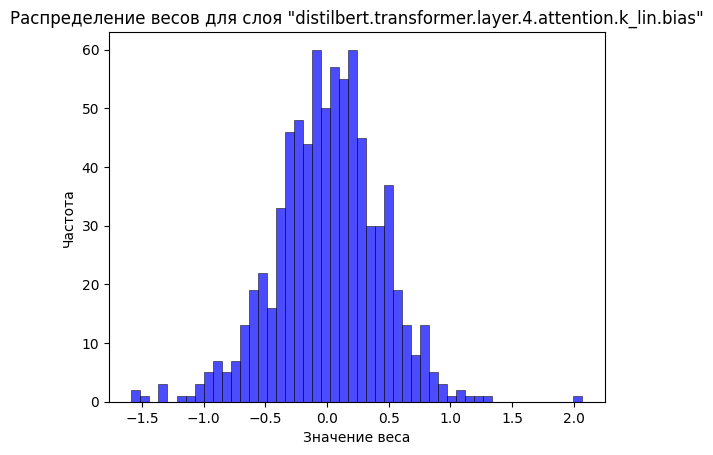

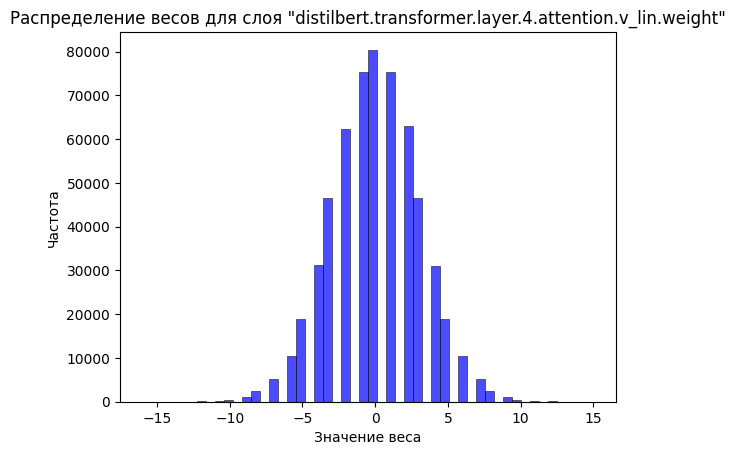

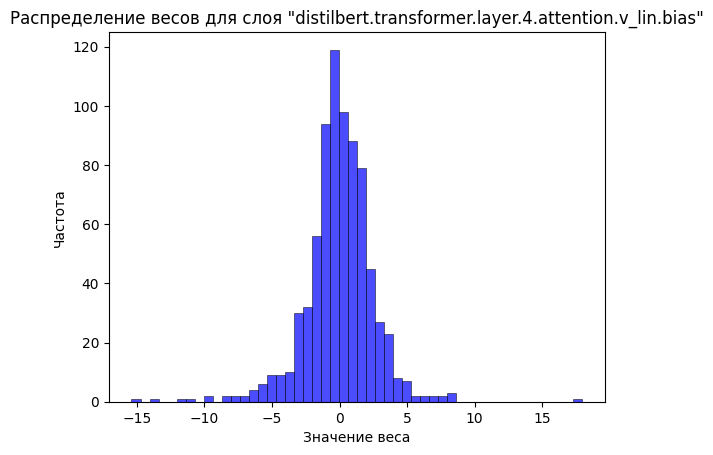

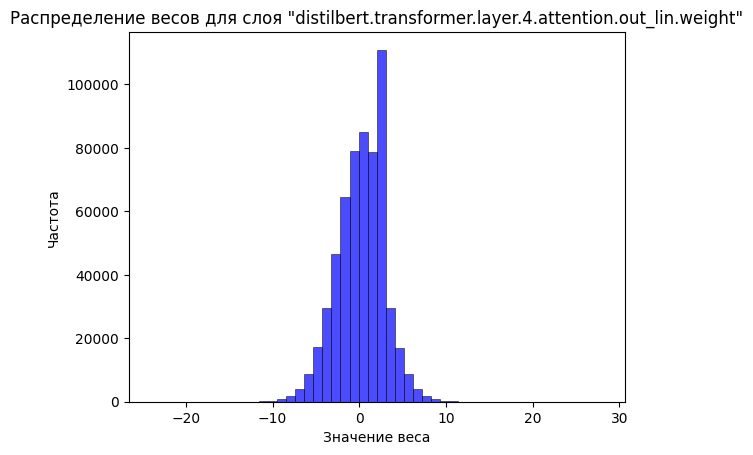

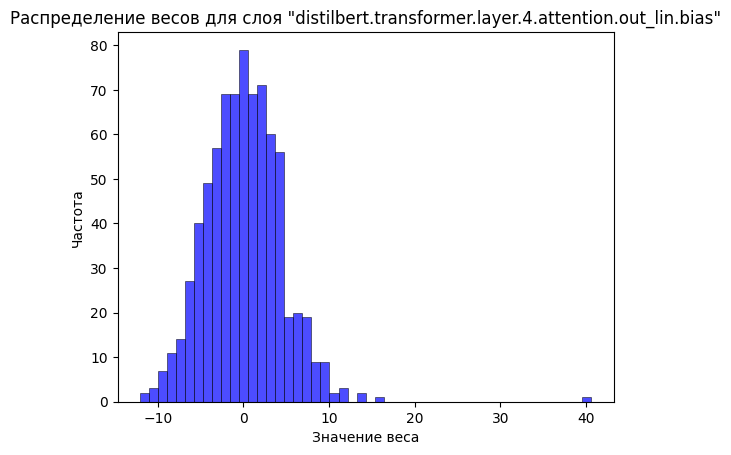

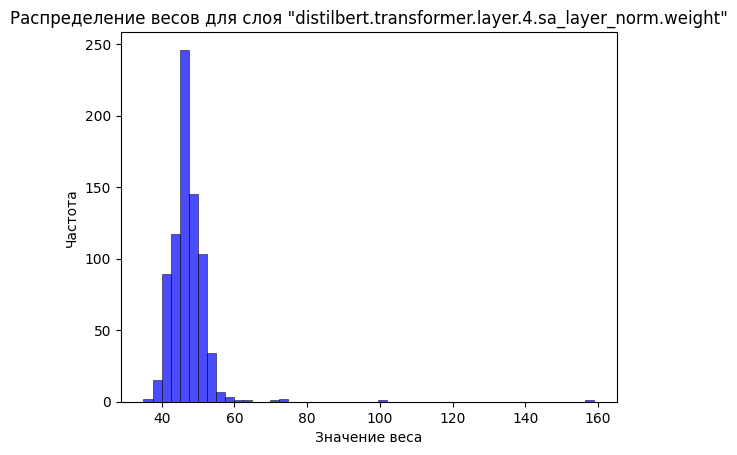

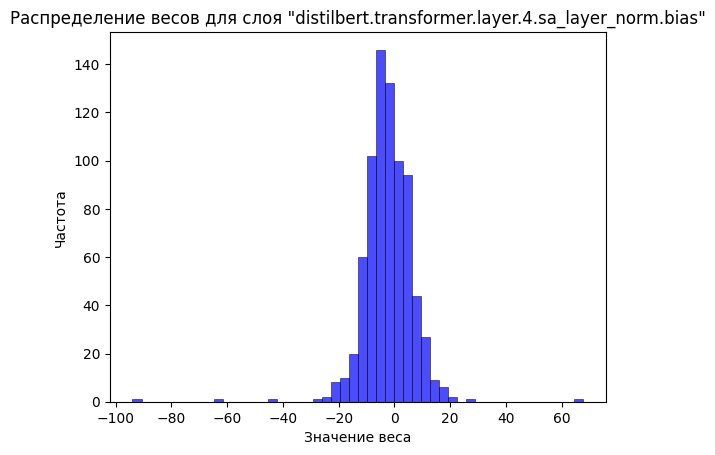

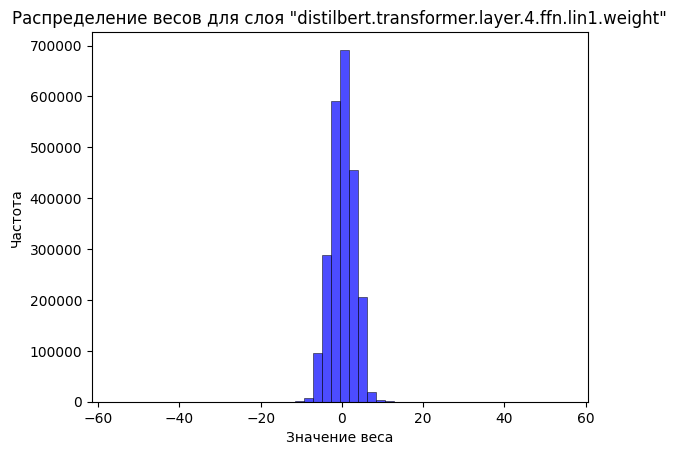

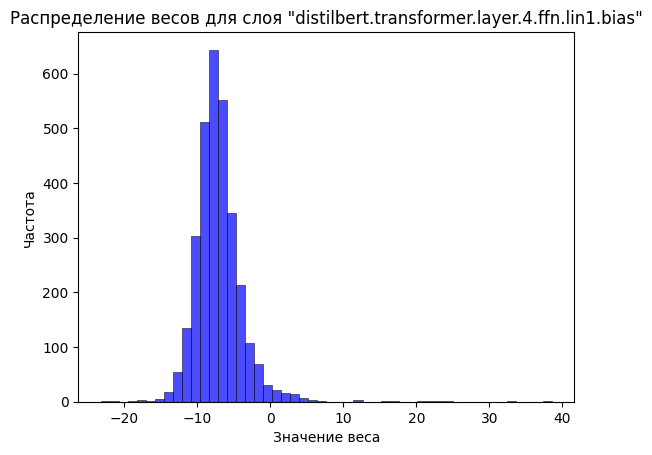

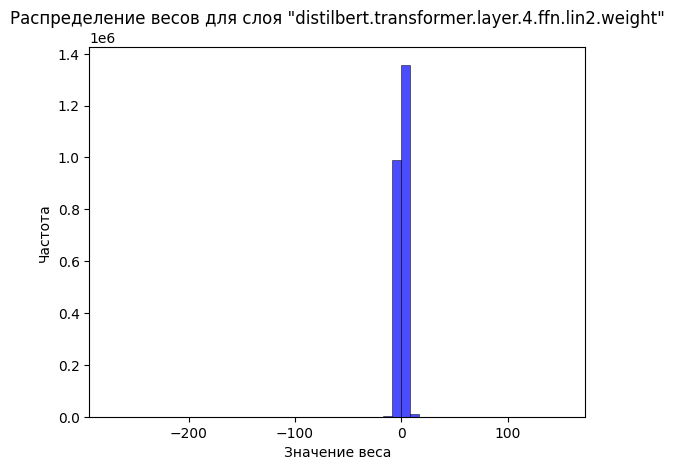

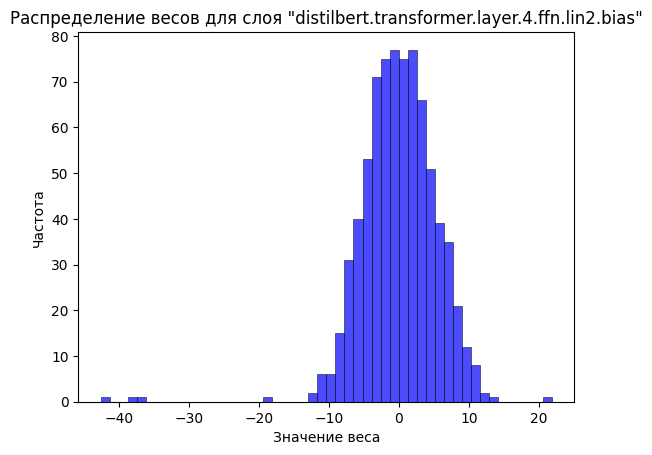

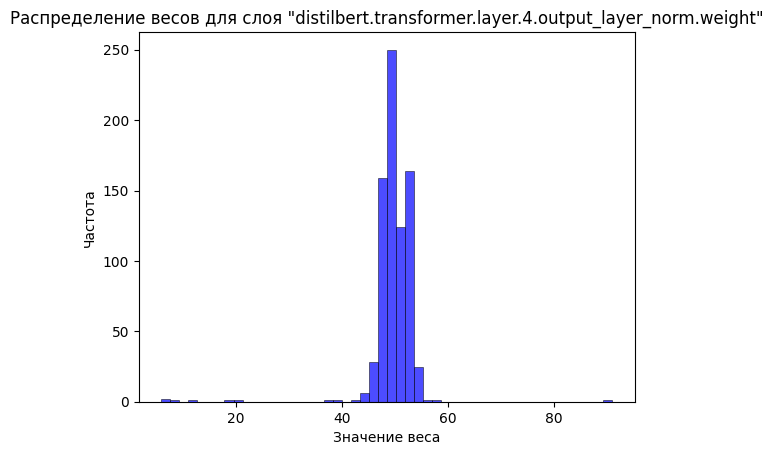

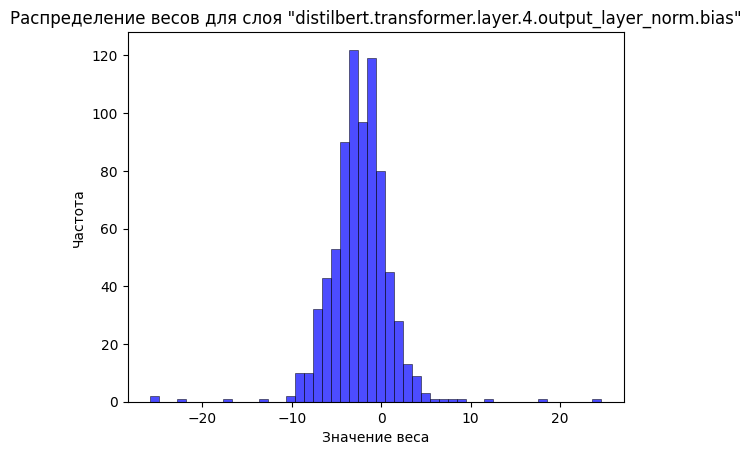

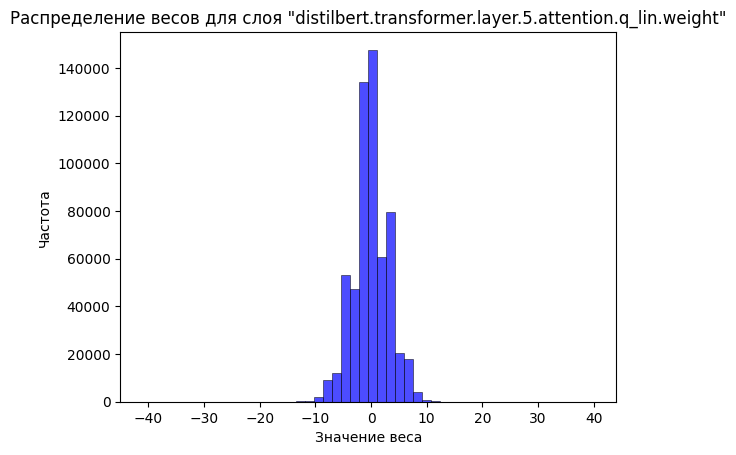

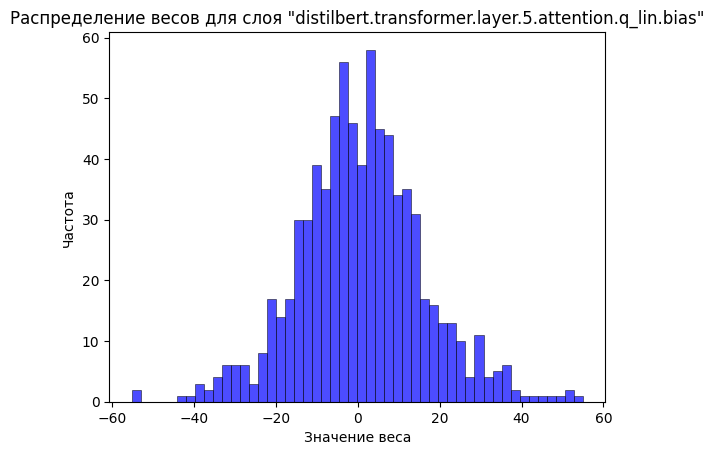

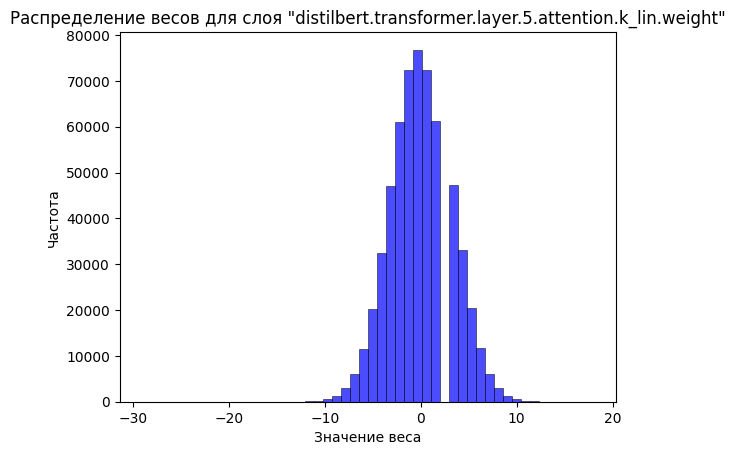

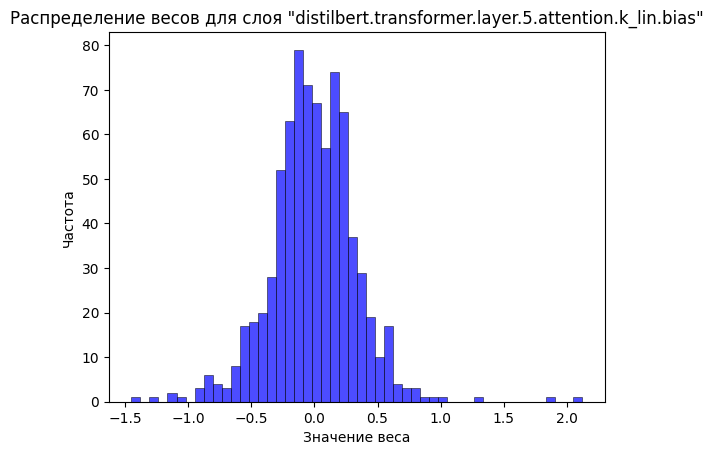

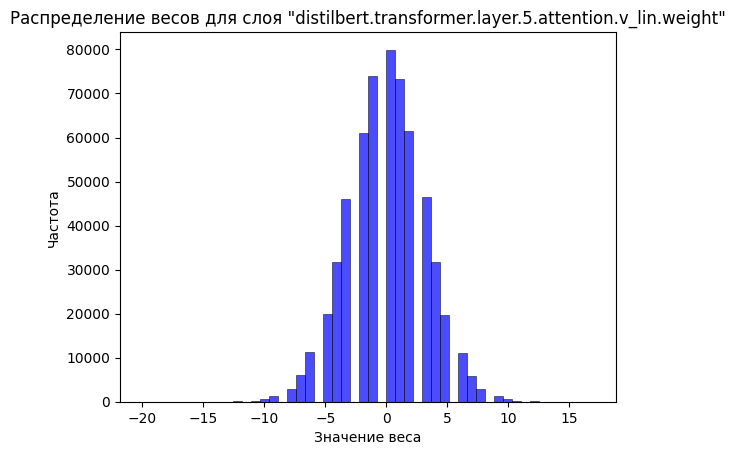

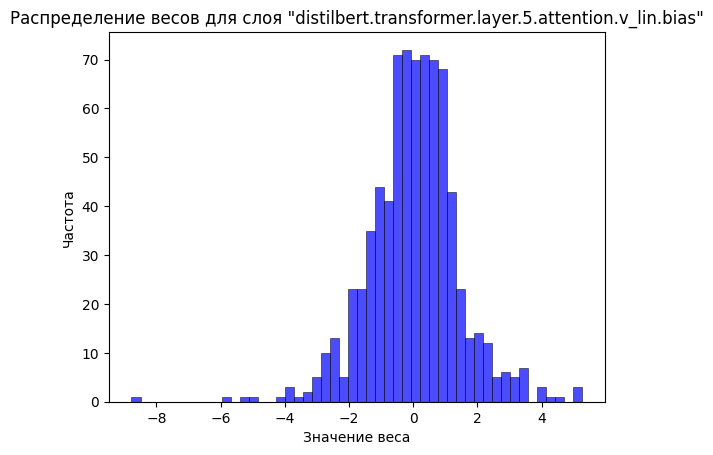

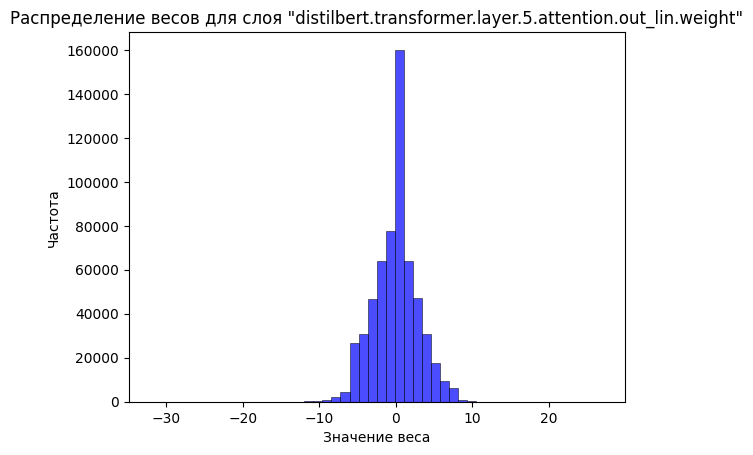

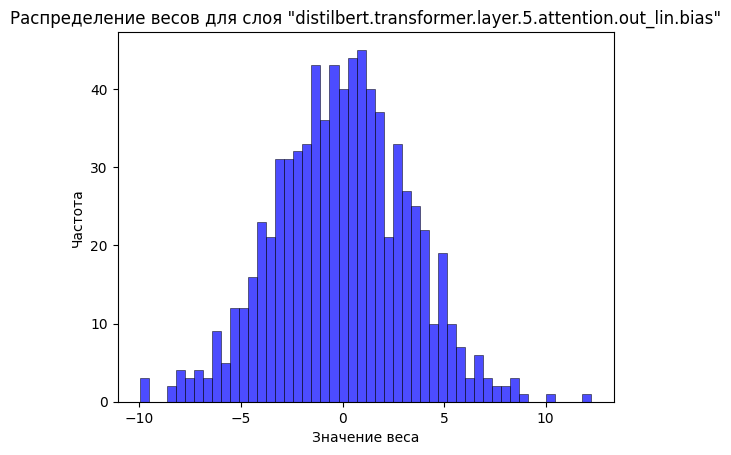

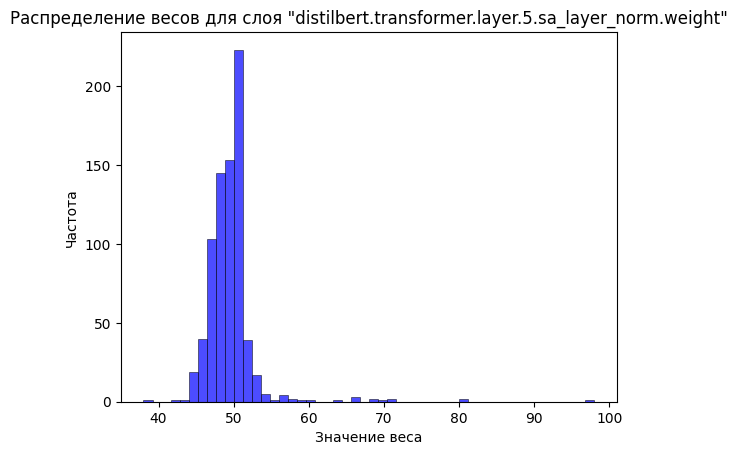

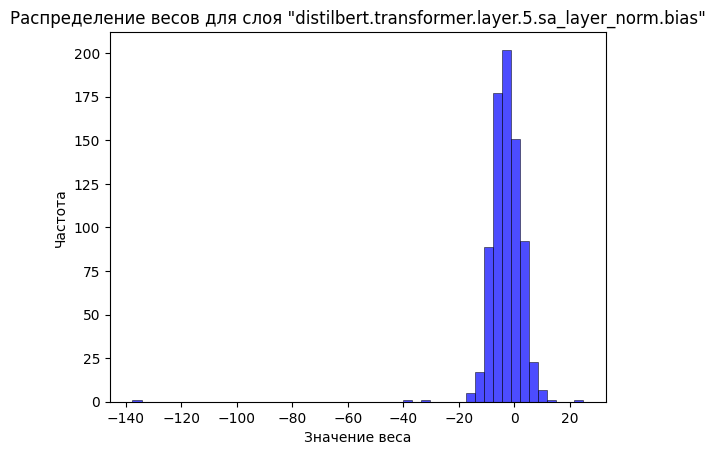

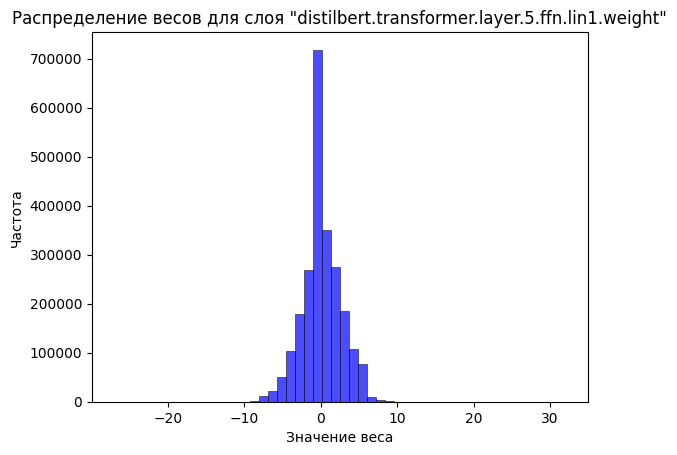

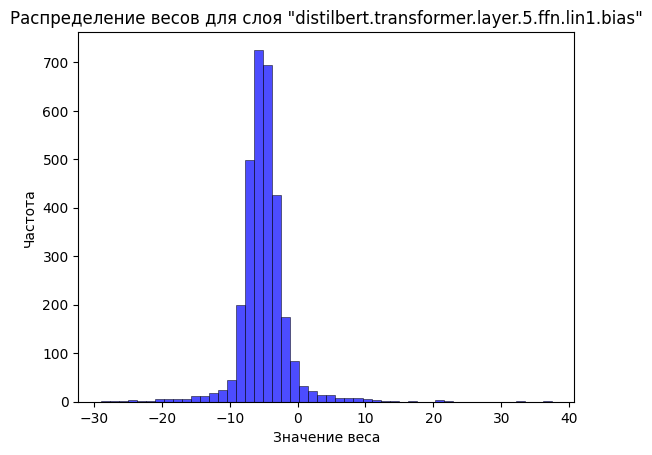

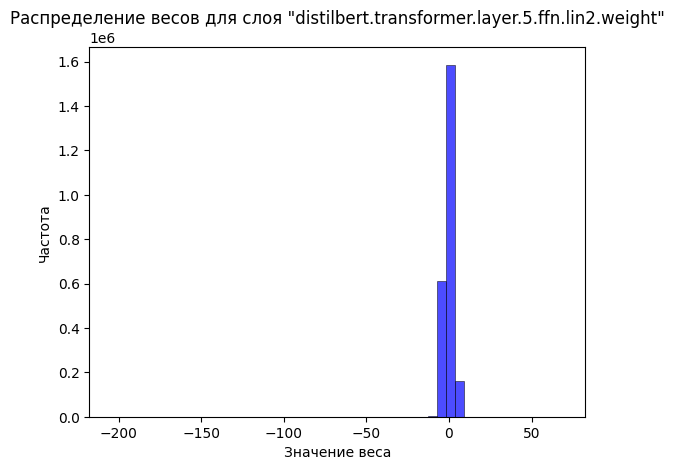

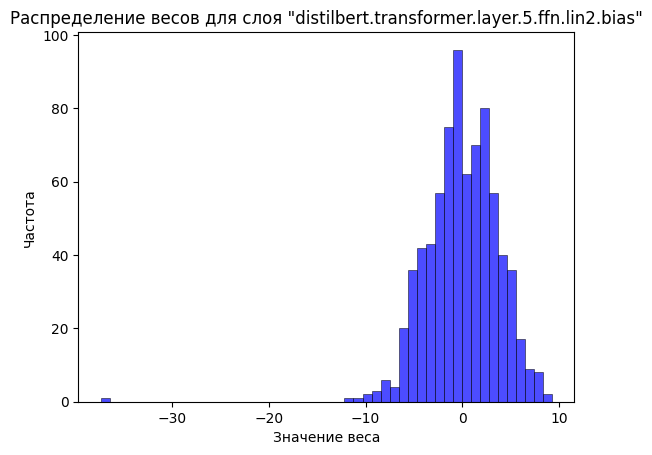

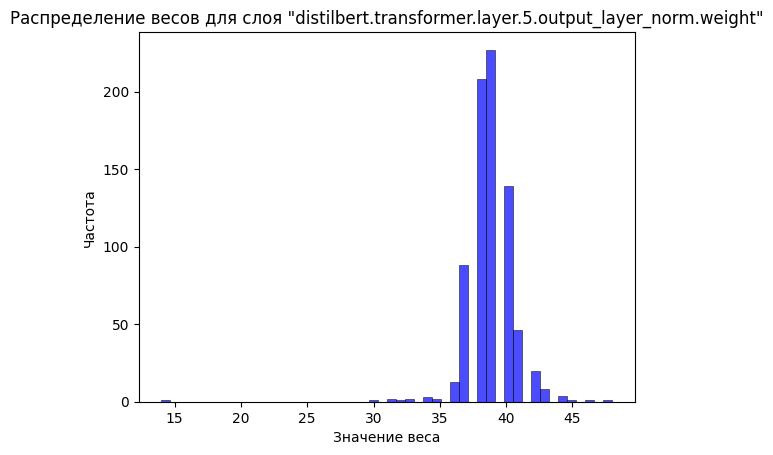

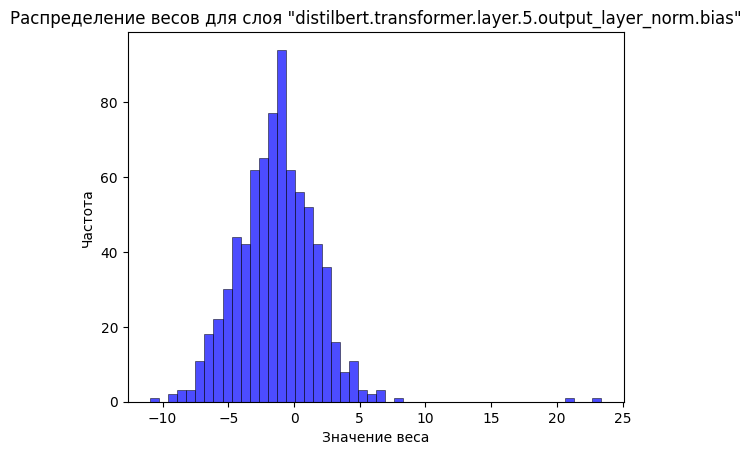

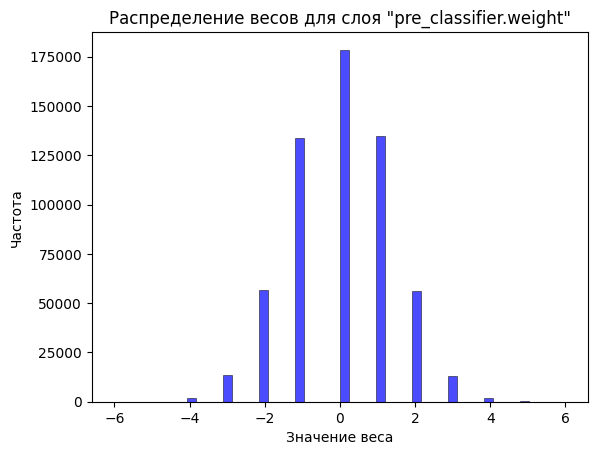

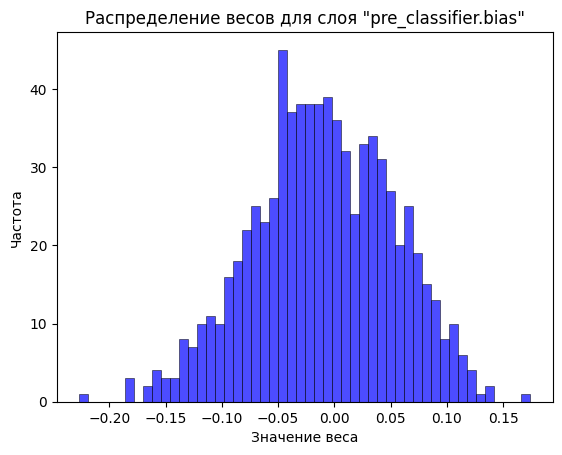

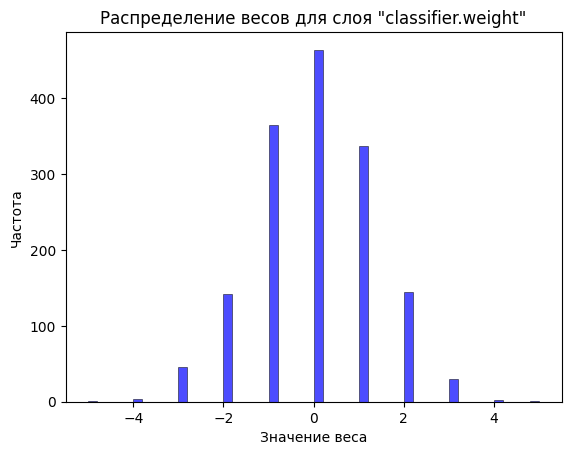

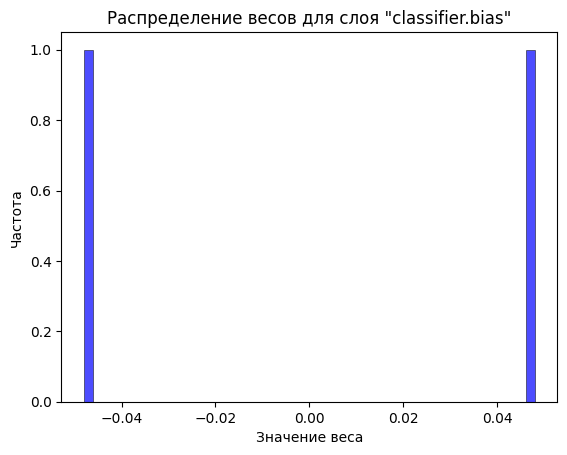

In [61]:
quantized_weights = torch.load('qDBERT(7).pth')

for key, value in quantized_weights.items():
    quantized_weights[key] = value * (1 << (7 - 1))

for key, value in quantized_weights.items():
    weights = value.cpu().numpy().flatten()
    plt.hist(weights, edgecolor='black', linewidth=0.5, bins=50, color='blue', alpha=0.7)
    plt.title(f'Распределение весов для слоя "{key}"')
    plt.xlabel('Значение веса')
    plt.ylabel('Частота')
    plt.grid(False)
    plt.show()